# Glucose Analysis

Author: Lawrence Baker

This file contains the code used to produce the figures and analysis 'Characterizing Blood Glucose Management in the Intensive Care Unit: Challenges and Opportunities for Big Data'. It is a subset of the code used to produce an MIT Master's Thesis in Technology and Policy 'Characterisation of Glucose Management in Intensive Care'. Complete (but messier) code can be found at: https://github.com/lawbaker/MIMIC-Glucose-Management 

To run this code requires that 'Generate Tables' has already successfully run in the same directory and that the .pkl file produced by this code is accessiable. This code boths cleans that data and produces the plots and summary statisitics used in the paper. Some results and figures that were not included in the paper have been left in if they help to provide context.

## Import Packages

In [48]:
import matplotlib as mpl
import matplotlib.colors as colors
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import plotly.offline as py
import matplotlib.patches as patches
import os, sys, pickle, json, time, math, re, copy, urllib, random, gc, pydotplus
import matplotlib.gridspec as gridspec
import sklearn as skl
import statsmodels.api as sm

from IPython.display import display
from datetime import timedelta
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from fractions import Fraction
from scipy.stats import ks_2samp
from matplotlib.ticker import PercentFormatter
from IPython.display import Image

py.init_notebook_mode(connected=False)

## Define Functions

In [85]:
#Functions

#finding impact of exclusions
def num_entries(df, old_size, exclu_str):
    new_size=len(df)
    print("\nExclusion:", exclu_str)
    print("Removed: ", old_size-new_size)
    print("Remaining: ", new_size)
    return new_size


#add patches to a graph to demonstrate glucose guidelines
def add_glucose_guidlines(lim1=80, lim2=180, lim3=180, zorder=10, alpha=0.05, lines=False):
    #Hypoglycaemic
    rect=patches.Rectangle((-1,0), 100, lim1, edgecolor="none", facecolor="r", alpha=alpha, zorder=zorder)
    ax.add_patch(rect)

    #Recommended
    rect=patches.Rectangle((-1,lim1), 100, lim2-lim1, edgecolor="none", facecolor="g", alpha=alpha, zorder=zorder)
    ax.add_patch(rect)
    
    #Hyperglycaemic
    rect=patches.Rectangle((-1,lim2), 100, lim3-lim2, edgecolor="none", facecolor="y", alpha=alpha, zorder=zorder)
    ax.add_patch(rect)
    
    #Very Hyperglycaemic
    rect=patches.Rectangle((-1,lim3), 100, lim3+1000, edgecolor="none", facecolor="r", alpha=alpha, zorder=zorder)
    ax.add_patch(rect)
    
    #Add lines
    if lines==True:
        ax.axhline(y=lim1, color="red", alpha=0.7, linewidth=1)
        ax.axhline(y=lim2, color="red", alpha=0.7, linewidth=1)
        
    return None


#Rounding (for heatmap categories)
def myround(x, base):
    return int(base * round(float(x)/base))


#Function for getting the time weighted averag
def time_weight(x):
    try:
        weighted_av=np.average(x.value, weights=x.weight)
        return weighted_av
    except (ZeroDivisionError):
         return np.mean(x.value)

        
#Reorganises glucose use into a daily format
def format_daily_glc(input_df, merge_col, col_rename, map_dict):
    #Create a long-form dataframe
    df=pd.melt(frame=input_df.iloc[:,0:7].reset_index(), id_vars="index", value_name="Glucose", var_name="Day")

    #Change timestamp into integer for easier plotting, and make first day '1'
    df["Day"]=(df["Day"].dt.days.astype(int)+1)

    #join diabetic status from admissions on icustay_id
    df=df.rename(index=str, columns={"index": "icustay"})
    df=admissions[[merge_col, "icustay"]].merge(df,  "left", on="icustay")
    df=df.rename(index=str, columns={merge_col: col_rename})
    df[col_rename]=df[col_rename].map(map_dict)
    
    return df


#Finds the proportion of patients who have blood sugars beyond a specified level
def proportion_beyond_lim(df, lim, dia, day, bound):
    df_temp=df.loc[df["Day"]==day].loc[df["Diabetes"]==dia].dropna()
    if bound=='hypo':
        prop=df_temp.loc[df["Glucose"]<lim].shape[0]/df_temp.shape[0]
        return round(prop,4)
    elif bound=='hyper':
        prop=df_temp.loc[df["Glucose"]>lim].shape[0]/df_temp.shape[0]
        return round(prop,4)
        
    return None


#Changes the index from a timestamp into a number of day
def ts_to_days(ts):
    ts.index=ts.index.days+ts.index.seconds/3600/24
    return ts


#Tidies graphics on patient ICU stay
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

        
#Set the end_timestamp equal to the start_timestamp for overlapping inputs
def align_overlaps(df, print_mods=True):
    #find column locations for needed columns
    start_iloc = df.columns.get_loc('input_start')
    end_iloc = df.columns.get_loc('input_end')
    icustay_iloc = df.columns.get_loc('icustay')
    
    #initate the mod count
    mod_count=0
    
    #loop throgh each line
    for i in range(1, len(df)):
        #check that we aren't starting a new icustay
        if df.iat[i-1, icustay_iloc] == df.iat[i, icustay_iloc]:
            curr_input_end= df.iat[i-1, end_iloc]
            next_input_start= df.iat[i, start_iloc]
            #if there is an overlap then change the end of the current input
            if curr_input_end > next_input_start:
                df.iat[i-1, end_iloc] = next_input_start
                mod_count+=1
                
    if print_mods==True:
        print ("Number of modifications made", mod_count)
        
    return df

## Data Loading

Load in data from the .pkl file produced by 'generate tables'

In [3]:
#Load data
(admissions, inputs, charts, labs, icd9, sofa, blood_labs) = pickle.load(open('./processed_data/insulin_adms.pkl', 'rb'))

#Create list of ICU stays
icustays=admissions["icustay"].values.tolist()
dia_icustays=admissions.loc[admissions.diabetic==1]["icustay"].values.tolist()
no_dia_icustays=admissions.loc[admissions.diabetic==0]["icustay"].values.tolist()

#add weight data to admissions
weight_df=charts.loc[charts["item"]==226512].groupby("icustay").mean().reset_index()
weight_df=weight_df.rename(columns={"value":"weight_kg"})
admissions=admissions.merge(weight_df[["icustay","weight_kg"]], how="left", on="icustay")

blood_labs=blood_labs.set_index('charttime')
blood_labs=blood_labs.rename({'icustay_id':'icustay', 'hadm_id':'hadm'}, axis='columns')

sofa=sofa.rename({'starttime':'charttime'}, axis='columns')
sofa=sofa.set_index('charttime')

## Data cleaning and formatting

Data cleaning is split into four different sections:

- Glucose Measurements
- Insulin Inputs
- Dextrose Inputs
- Feeding (Nutritional) Inputs

Nutritional inputs were not used in the paper, but the code is here for those who may want to use this information in their own research.

In each case the dataframes are formatted, have informative columns added and are filtered to clean the data. Exclusion rules and number of cases dropped are printed. For dextrose and insulin infusions, the algin_overlaps function is used to modify infusion lengths so patients are only receiving one infusion of each type at one time.

### Glucose measurements cleaning and formatting

In [4]:
#Glucose measurements
#identify all glucose measurements
glucose_chart_labels = ['Glucose finger stick','Glucose (whole blood)','Glucose (serum)', 'Fingerstick Glucose',
                      'Glucose (70-105)', 'Glucose', 'Blood Glucose', 'BloodGlucose']

glucose_lab_labels = ['Glucose']


#filter just the glucose measurements
glc_charts=charts[charts['label'].isin(glucose_chart_labels)]

#need to add in labs
glc_labs=labs[labs['label'].isin(glucose_lab_labels)]

#join the tables
glc_measurements=pd.concat([glc_charts, glc_labs])

#add in the icu entry and discharge times from admissions
glc_measurements=admissions[["icustay","icu_admit", "icu_discharge"]].merge(glc_measurements, "right")

#convert to datetime
for col in ["icu_admit", "icu_discharge", "charttime"]:
    glc_measurements[col]=pd.to_datetime(glc_measurements[col])

#create relative time (in days)
#glc_measurements["icu_time"]=(glc_measurements["charttime"]-glc_measurements["icu_admit"]).dt.seconds/3600/24+(glc_measurements["charttime"]-glc_measurements["icu_admit"]).dt.days
glc_measurements["icu_time"]=(glc_measurements["charttime"]-glc_measurements["icu_admit"])


old_size=len(glc_measurements)
#drop bad IDs
glc_measurements=glc_measurements.loc[glc_measurements.item != 51478]
old_size=num_entries(glc_measurements, old_size, "Drop ID 51478")

glc_measurements=glc_measurements.loc[glc_measurements.item != 50809]
old_size=num_entries(glc_measurements, old_size, "Drop ID 50809")

glc_measurements=glc_measurements.loc[glc_measurements.item != 50931]
old_size=num_entries(glc_measurements, old_size, "Drop ID 50931")

#Define Glucose types
glc_dict={225664: "Fingerstick", 220621: "Serum", 1529: "Serum",
         811: "Serum", 807: "Fingerstick", 50931: "Serum", 226537: "Serum",
          50809: "Serum"}

glc_measurements["type"]= glc_measurements["item"].map(glc_dict)

#drop errors
glc_measurements=glc_measurements.drop(glc_measurements.loc[glc_measurements.error==1].index)
old_size=num_entries(glc_measurements, old_size, "Drop error entries")

#drop duplicated values
glc_measurements=glc_measurements.drop_duplicates(["icu_time", "icustay", "value", "type"],keep= 'first')
old_size=num_entries(glc_measurements, old_size, "Drop duplicates")

#drop missing values
glc_measurements=glc_measurements.dropna(subset=["value"])
old_size=num_entries(glc_measurements, old_size, "Drop missing amount values")

#drop measurements that occur before or after stay
glc_measurements=glc_measurements[glc_measurements.charttime > glc_measurements.icu_admit]
glc_measurements=glc_measurements[glc_measurements.charttime < glc_measurements.icu_discharge]
old_size=num_entries(glc_measurements, old_size, "Drop timestamp before / after stay")

#set index as the time after entry
glc_measurements=glc_measurements.set_index("icu_time")

#sort in order
glc_measurements=glc_measurements.sort_values(by=["icustay", "charttime"])

#remove values over 1000 for glucose measurements
glc_measurements=glc_measurements.drop(glc_measurements.loc[(glc_measurements.label.str.contains("Glucose")) & (glc_measurements.value>1000)].index)
old_size=num_entries(glc_measurements, old_size, "Values over or equal to 1000")

#remove values which are too low (<10) for glucose measurements
glc_measurements=glc_measurements.drop(glc_measurements.loc[(glc_measurements.label.str.contains("Glucose")) & (glc_measurements.value<=10)].index)
old_size=num_entries(glc_measurements, old_size, "Values under 10")

#remove values over 499 for fingersrick measurements
glc_measurements=glc_measurements.drop(glc_measurements.loc[(glc_measurements.label.isin(["Fingerstick Glucose", "Glucose finger stick"])) & (glc_measurements.value>=499)].index)
old_size=num_entries(glc_measurements, old_size, "Fingerstick value over 499")

#drop error and warning columns
glc_measurements=glc_measurements.drop(['warning', 'error'], axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.





Exclusion: Drop ID 51478
Removed:  22188
Remaining:  789017

Exclusion: Drop ID 50809
Removed:  62437
Remaining:  726580

Exclusion: Drop ID 50931
Removed:  277674
Remaining:  448906

Exclusion: Drop error entries
Removed:  3002
Remaining:  445904

Exclusion: Drop duplicates
Removed:  5754
Remaining:  440150

Exclusion: Drop missing amount values
Removed:  19
Remaining:  440131

Exclusion: Drop timestamp before / after stay
Removed:  1276
Remaining:  438855

Exclusion: Values over or equal to 1000
Removed:  68
Remaining:  438787

Exclusion: Values under 10
Removed:  172
Remaining:  438615

Exclusion: Fingerstick value over 499
Removed:  204
Remaining:  438411


### Insulin inputs cleaning and formatting

In [6]:
#Insulin inputs
insulin_inputs=inputs.loc[(inputs.label.str.contains("Insulin"))]

insulin_inputs=admissions[["icustay","icu_admit", "icu_discharge"]].merge(insulin_inputs, "right", on="icustay")

#convert to datetime
for col in ["input_start", "input_end", "icu_admit", "icu_discharge"]:
    insulin_inputs[col]=pd.to_datetime(insulin_inputs[col])

#create relative time (in days)
insulin_inputs["icu_time"]=(insulin_inputs["input_start"]-insulin_inputs["icu_admit"])

#Insulin administration type
insulin_inputs["delivery"]="Bolus"
insulin_inputs.loc[(insulin_inputs.totalamountuom=='ml'),"delivery"]="Infusion"

old_size=len(insulin_inputs)
print("Original Length", old_size)

#drop errors
insulin_inputs=insulin_inputs.drop(insulin_inputs.loc[insulin_inputs.status=='Rewritten'].index)
old_size=num_entries(insulin_inputs, old_size, "Drop Errors")

#drop duplicated values
insulin_inputs=insulin_inputs.drop_duplicates(["icu_time", "icustay", "amount", "item", "delivery", "input_start", "input_end"], keep= 'last')
old_size=num_entries(insulin_inputs, old_size, "Drop Duplicates")

#drop bolus with missing data
insulin_inputs=insulin_inputs.drop(insulin_inputs[np.isnan((insulin_inputs.amount))&(insulin_inputs.delivery=="Bolus")].index)
old_size=num_entries(insulin_inputs, old_size, "Drop Boluses with missing amount data")
#drop infusions with missing data
insulin_inputs=insulin_inputs.drop(insulin_inputs[np.isnan((insulin_inputs.rate))&(insulin_inputs.delivery=="Infusion")].index)
old_size=num_entries(insulin_inputs, old_size, "Drop Infusions with missing rate data")


#drop measurements that occur before or after stay
insulin_inputs=insulin_inputs[insulin_inputs.input_start > insulin_inputs.icu_admit]
insulin_inputs=insulin_inputs[insulin_inputs.input_start < insulin_inputs.icu_discharge]
old_size=num_entries(insulin_inputs, old_size, "Drop timestamp before/after stay")

#add in type data
insulin_type_dict={223260: "Long", 223262: "Short", 223258: "Short",
         223257: "Intermediate", 223259: "Intermediate", 223261: "Intermediate"}

insulin_inputs["type"]= insulin_inputs["item"].map(insulin_type_dict)

#show number split
print("Number of Bolus:", len(insulin_inputs.loc[insulin_inputs.delivery=="Bolus"]))
print("Number of Infusion:", len(insulin_inputs.loc[insulin_inputs.delivery=="Infusion"]))

      
#drop values which are too small or too large
#drop negative or zero boluses
insulin_inputs=insulin_inputs.drop(insulin_inputs.loc[(insulin_inputs["amount"]<=0)&(insulin_inputs["delivery"]=="Bolus")].index)
old_size=num_entries(insulin_inputs, old_size, "Drop negative or zero bolus values")
#drop negative infusion amounts 
insulin_inputs=insulin_inputs.drop(insulin_inputs.loc[(insulin_inputs.rate<=0)&(insulin_inputs["delivery"]=="Infusion")].index)
old_size=num_entries(insulin_inputs, old_size, "Drop Negative infusion amounts")
#drop short boluses over 40U
insulin_inputs=insulin_inputs.drop(insulin_inputs[(insulin_inputs.amount>100)&(insulin_inputs.type=="Short")&(insulin_inputs.delivery=="Bolus")].index)
old_size=num_entries(insulin_inputs, old_size, "Drop Boluses over 100 Units")
#drop infusions over 20/hr
insulin_inputs=insulin_inputs.drop(insulin_inputs[(insulin_inputs.rate>100)&(insulin_inputs.delivery=="Infusion")].index)
old_size=num_entries(insulin_inputs, old_size, "Drop Infusions over 100 Units /hr")

#insulin_bolus
insulin_bolus=insulin_inputs.loc[insulin_inputs.delivery=="Bolus"]

#Insulin Infusions
insulin_infusion=insulin_inputs.loc[(insulin_inputs.delivery=="Infusion")]

old_size=len(insulin_infusion)
insulin_infusion.sort_values(by=["icustay", "input_start" , "input_end"], ascending=[True, True, True])
insulin_infusion=insulin_infusion.drop_duplicates(["icu_time", "icustay", "item", "delivery", "input_start"], keep= 'last')
old_size=num_entries(insulin_infusion, old_size, "Drop Duplicates (from infusion controls)")

#align
print("\n")
insulin_infusion=align_overlaps(insulin_infusion)

#Create variable for length of infusion
insulin_infusion.loc[:,"length_hr"]=insulin_infusion["input_end"]-insulin_infusion["input_start"]
#convert time difference into hours
insulin_infusion.loc[:,"length_hr"]=24*(insulin_infusion["length_hr"].dt.days+insulin_infusion["length_hr"].dt.seconds/3600/24)

#drop zero/short length infusions
insulin_infusion=insulin_infusion.drop(insulin_infusion.loc[(insulin_infusion["length_hr"]<=(1/60))].index)
old_size=num_entries(insulin_infusion, old_size, "Drop Infusions with less than 1 minute length")

#establish the real amount delivered
insulin_infusion["raw_amount"]=insulin_infusion["amount"]
insulin_infusion["amount"]=insulin_infusion["rate"]*insulin_infusion["length_hr"]

#reconstruct insulin_inputs
insulin_inputs=pd.concat([insulin_infusion, insulin_bolus], sort=False).sort_index()

#drop unneeded columns
insulin_bolus=insulin_bolus.drop(['rate', 'rateuom', 'totalamount', 'totalamountuom'], axis=1)

print("\n final size:", len(insulin_inputs))

Original Length 188018

Exclusion: Drop Errors
Removed:  14964
Remaining:  173054

Exclusion: Drop Duplicates
Removed:  0
Remaining:  173054

Exclusion: Drop Boluses with missing amount data
Removed:  0
Remaining:  173054

Exclusion: Drop Infusions with missing rate data
Removed:  1525
Remaining:  171529

Exclusion: Drop timestamp before/after stay
Removed:  24406
Remaining:  147123
Number of Bolus: 103324
Number of Infusion: 43799

Exclusion: Drop negative or zero bolus values
Removed:  3302
Remaining:  143821

Exclusion: Drop Negative infusion amounts
Removed:  0
Remaining:  143821

Exclusion: Drop Boluses over 100 Units
Removed:  14
Remaining:  143807

Exclusion: Drop Infusions over 100 Units /hr
Removed:  35
Remaining:  143772

Exclusion: Drop Duplicates (from infusion controls)
Removed:  0
Remaining:  43764


Number of modifications made 35

Exclusion: Drop Infusions with less than 1 minute length
Removed:  221
Remaining:  43543

 final size: 143551


### Dextrose inputs cleaning and formatting

In [7]:
#Dextrose inputs
dextrose_inputs=inputs.loc[(inputs.label.str.contains("Dextrose"))]
dextrose_inputs=admissions[["icustay","icu_admit", "icu_discharge"]].merge(dextrose_inputs, "right", on="icustay")

#convert to datetime
for col in ["input_start", "input_end", "icu_admit", "icu_discharge"]:
    dextrose_inputs[col]=pd.to_datetime(dextrose_inputs[col])

#create relative time (in days)
dextrose_inputs["icu_time"]=(dextrose_inputs["input_start"]-dextrose_inputs["icu_admit"])


old_size=len(dextrose_inputs)
print("Original size:", old_size)

#drop errors
dextrose_inputs=dextrose_inputs.drop(dextrose_inputs.loc[dextrose_inputs.status=='Rewritten'].index)
old_size=num_entries(dextrose_inputs, old_size, "Drop Errors")

#drop duplicated values
dextrose_inputs=dextrose_inputs.drop_duplicates(["icu_time", "icustay", "item"], keep= 'last')
old_size=num_entries(dextrose_inputs, old_size, "Drop Duplicates")

#drop measurements that occur before or after stay
dextrose_inputs=dextrose_inputs[dextrose_inputs.input_start > dextrose_inputs.icu_admit]
dextrose_inputs=dextrose_inputs[dextrose_inputs.input_start < dextrose_inputs.icu_discharge]
old_size=num_entries(dextrose_inputs, old_size, "Drop timestamp before or after stay")

#drop those with negative amount information
dextrose_inputs=dextrose_inputs.drop(dextrose_inputs[(dextrose_inputs.amount<=0)].index)
old_size=num_entries(dextrose_inputs, old_size, "Drop negative amount")

#add concentration
dextrose_inputs.loc[dextrose_inputs.label.str.contains("5%"), "concentration"]=0.05
dextrose_inputs.loc[dextrose_inputs.label.str.contains("PN"), "concentration"]=0.05
dextrose_inputs.loc[dextrose_inputs.label.str.contains("10%"), "concentration"]=0.1
dextrose_inputs.loc[dextrose_inputs.label.str.contains("20%"), "concentration"]=0.2
dextrose_inputs.loc[dextrose_inputs.label.str.contains("50%"), "concentration"]=0.5

#define type (bolus is close to instant)
dextrose_inputs["delivery"]="Infusion"
dextrose_inputs.loc[dextrose_inputs.rate.isna()==True, "delivery"]="Bolus"

#define bolus and drop unneeded columns
dextrose_bolus=dextrose_inputs.loc[(dextrose_inputs.delivery=="Bolus")]

#Dextrose Infusions
dextrose_infusion=dextrose_inputs.loc[(dextrose_inputs.delivery=="Infusion")]

old_size=len(dextrose_infusion)
dextrose_infusion.sort_values(by=["icustay", "input_start" , "input_end"], ascending=[True, True, True])
dextrose_infusion=dextrose_infusion.drop_duplicates(["icu_time", "icustay", "item", "delivery", "input_start"], keep= 'last')
old_size=num_entries(dextrose_infusion, old_size, "Drop Duplicates (from infusion controls)")

#align
print("\n")
dextrose_infusion=align_overlaps(dextrose_infusion)

#Create variable for length of infusion
dextrose_infusion.loc[:,"length_hr"]=dextrose_infusion["input_end"]-dextrose_infusion["input_start"]
#convert time difference into hours
dextrose_infusion.loc[:,"length_hr"]=24*(dextrose_infusion["length_hr"].dt.days+dextrose_infusion["length_hr"].dt.seconds/3600/24)

#drop zero/short length infusions
dextrose_infusion=dextrose_infusion.drop(dextrose_infusion.loc[(dextrose_infusion["length_hr"]<=(1/60))].index)
old_size=num_entries(dextrose_infusion, old_size, "Drop Infusions with less than 1 minute length")

#establish the real amount delivered
dextrose_infusion["raw_amount"]=dextrose_infusion["amount"]
dextrose_infusion["amount"]=dextrose_infusion["rate"]*dextrose_infusion["length_hr"]

#reconstruct insulin_inputs
dextrose_inputs=pd.concat([dextrose_infusion, dextrose_bolus], sort=False).sort_index()

#define ml dextrose/hr
dextrose_inputs["dxt_rate"]=dextrose_inputs["concentration"]*dextrose_inputs["rate"]
dextrose_inputs["dxt_amount"]=dextrose_inputs["concentration"]*dextrose_inputs["amount"]

#define bolus and drop unneeded columns
dextrose_bolus=dextrose_inputs.loc[(dextrose_inputs.delivery=="Bolus")]

#Dextrose Infusions
dextrose_infusion=dextrose_inputs.loc[(dextrose_inputs.delivery=="Infusion")]

#drop unneeded bolus columns
dextrose_bolus=dextrose_bolus.drop(['rate', 'rateuom', 'totalamount', 'totalamountuom'], axis=1)

print("\n final size:", len(dextrose_inputs))

Original size: 479879

Exclusion: Drop Errors
Removed:  87040
Remaining:  392839

Exclusion: Drop Duplicates
Removed:  7911
Remaining:  384928

Exclusion: Drop timestamp before or after stay
Removed:  60590
Remaining:  324338

Exclusion: Drop negative amount
Removed:  56
Remaining:  324282

Exclusion: Drop Duplicates (from infusion controls)
Removed:  0
Remaining:  142768


Number of modifications made 31268

Exclusion: Drop Infusions with less than 1 minute length
Removed:  1649
Remaining:  141119

 final size: 322633


### Nutritional inputs cleaning and formatting

In [8]:
parenteral_labels=['TPN w/ Lipids', 'TPN without Lipids', 'Peripheral Parenteral Nutrition']

enteral_labels=['Replete with Fiber (Full)', 'Nutren Renal (Full)',
                    'Impact with Fiber (1/4)', 'Boost Glucose Control (Full)',
                   'Beneprotein', 'Nutren 2.0 (Full)', 'Fibersource HN (Full)',
                   'NovaSource Renal (Full)', 'Nutren Pulmonary (Full)',
                   'Peptamen 1.5 (Full)', 'ProBalance (Full)', 'Impact (Full)',
                   'Isosource 1.5 (Full)', 'Vivonex (Full)',
                   'Peptamen Bariatric (Full)', 'Replete (Full)', 'Pulmocare (Full)',
                   'Impact with Fiber (Full)', 'Replete with Fiber (1/2)',
                   'Two Cal HN (Full)', 'Glucerna (Full)', 'Two Cal HN (1/2)',
                   'Nepro (Full)', 'Nutren 2.0 (1/4)', 'Nutren 2.0 (1/2)',
                   'Replete with Fiber (1/4)', 'Ensure (Full)', 'Replete (1/2)',
                   'Impact (1/4)', 'Replete (3/4)', 'Replete with Fiber (3/4)',
                   'Fibersource HN (1/2)', 'Peptamen 1.5 (1/2)',
                   'Fibersource HN (1/4)', 'Peptamen 1.5 (1/4)',
                   'Nutren Pulmonary (1/2)', 'Ensure Plus (Full)', 'Ensure (1/4)',
                   'Boost Glucose Control (1/4)', 'Nutren Renal (1/2)',
                   'Nutren Renal (3/4)', 'Replete (1/4)', 'Nutren Renal (1/4)',
                   'Impact with Fiber (1/2)', 'Impact (1/2)', 'Vivonex (3/4)',
                   'Nutren 2.0 (3/4)', 'Peptamen 1.5 (3/4)', 'Impact (3/4)',
                   'Isosource 1.5 (1/2)', 'Isosource 1.5 (3/4)',
                   'NovaSource Renal (3/4)', 'Pulmocare (1/4)',
                   'NovaSource Renal (1/2)', 'Boost Glucose Control (3/4)',
                   'Nepro (1/2)', 'Impact with Fiber (3/4)', 'Fibersource HN (3/4)',
                   'Replete (2/3)', 'Boost Glucose Control (1/2)', 'Vivonex (1/2)',
                   'Nutren 2.0 (2/3)', 'Nutren Pulmonary (3/4)',
                   'Isosource 1.5 (1/4)', 'Replete with Fiber (2/3)', 'Impact (2/3)',
                   'Glucerna (1/2)', 'Ensure (3/4)', 'Isosource 1.5 (2/3)',
                   'Peptamen VHP (Full)']


feeding_labels=np.concatenate([parenteral_labels, enteral_labels])

In [9]:
feeding_inputs=inputs.loc[inputs.label.isin(feeding_labels)]


#add in the icu entry and discharge times from admissions
feeding_inputs=admissions[["icustay","icu_admit", "icu_discharge"]].merge(feeding_inputs, "right", on="icustay")

#convert to datetime
for col in ["input_start", "input_end", "icu_admit", "icu_discharge"]:
    feeding_inputs[col]=pd.to_datetime(feeding_inputs[col])

#create relative time (in days)
feeding_inputs["icu_time"]=(feeding_inputs["input_start"]-feeding_inputs["icu_admit"])

#Feeding administration type
feeding_inputs.loc[(feeding_inputs.label.isin(enteral_labels)),"delivery"]="Enteral"
feeding_inputs.loc[(feeding_inputs.label.isin(parenteral_labels)),"delivery"]="Parenteral"

#map the different labels to different concentrations 
feeding_inputs["concentration"]=1
#put PPN as 50% of TPN
feeding_inputs.loc[feeding_inputs.label=='Peripheral Parenteral Nutrition', "concentration"]=0.5
for frac in ["1/4", "1/2", "2/3", "3/4"]:
    decimal=float(Fraction(frac))
    feeding_inputs.loc[(feeding_inputs.label.str.contains(frac)),"concentration"]=decimal

old_size=len(feeding_inputs)
print("Original size:", old_size)

#drop errors
feeding_inputs=feeding_inputs.drop(feeding_inputs.loc[feeding_inputs.status=='Rewritten'].index)
old_size=num_entries(feeding_inputs, old_size, "Drop Errors")

#drop duplicated values
feeding_inputs=feeding_inputs.drop_duplicates(["icu_time", "icustay", "item"], keep= 'last')
old_size=num_entries(feeding_inputs, old_size, "Drop Duplicates")

#drop measurements that occur before or after stay
feeding_inputs=feeding_inputs[feeding_inputs.input_start > feeding_inputs.icu_admit]
feeding_inputs=feeding_inputs[feeding_inputs.input_start < feeding_inputs.icu_discharge]
old_size=num_entries(feeding_inputs, old_size, "Drop timestamp before or after stay")

#drop those missing rate information
feeding_inputs=feeding_inputs.dropna(subset=["rate"])
old_size=num_entries(feeding_inputs, old_size, "Drop missing rate")

#drop those with negative amount information
feeding_inputs=feeding_inputs.drop(feeding_inputs[(feeding_inputs.amount<=0)].index)
old_size=num_entries(feeding_inputs, old_size, "Drop negative amount")

#drop those with rates which are too high
feeding_inputs=feeding_inputs.drop(feeding_inputs[(feeding_inputs.rate>200)].index)
old_size=num_entries(feeding_inputs, old_size, "Drop rates above 200")

feeding_inputs.sort_values(by=["icustay", "input_start" , "input_end"], ascending=[True, True, True])
feeding_inputs=feeding_inputs.drop_duplicates(["icu_time", "icustay", "item", "delivery", "input_start"], keep= 'last')
old_size=num_entries(feeding_inputs, old_size, "Drop Duplicates (from input controls)")

#align
print("\n")
feeding_inputs=align_overlaps(feeding_inputs)

#Create variable for length of infusion
feeding_inputs.loc[:,"length_hr"]=feeding_inputs["input_end"]-feeding_inputs["input_start"]
#convert time difference into hours
feeding_inputs.loc[:,"length_hr"]=24*(feeding_inputs["length_hr"].dt.days+feeding_inputs["length_hr"].dt.seconds/3600/24)

#drop zero/short length infusions
feeding_inputs=feeding_inputs.drop(feeding_inputs.loc[(feeding_inputs["length_hr"]<=(1/60))].index)
old_size=num_entries(feeding_inputs, old_size, "Drop inputs with less than 1 minute length")

#establish the real amount delivered
feeding_inputs["raw_amount"]=feeding_inputs["amount"]
feeding_inputs["amount"]=feeding_inputs["rate"]*feeding_inputs["length_hr"]

#define effective_rate
feeding_inputs["eff_rate"]=feeding_inputs["concentration"]*feeding_inputs["rate"]
feeding_inputs["eff_amount"]=feeding_inputs["concentration"]*feeding_inputs["amount"]

#define enteral and parenteral
enteral_inputs=feeding_inputs.loc[(feeding_inputs.delivery=="Enteral")]
parenteral_inputs=feeding_inputs.loc[(feeding_inputs.delivery=="Parenteral")]

Original size: 157141

Exclusion: Drop Errors
Removed:  66876
Remaining:  90265

Exclusion: Drop Duplicates
Removed:  10
Remaining:  90255

Exclusion: Drop timestamp before or after stay
Removed:  17280
Remaining:  72975

Exclusion: Drop missing rate
Removed:  6710
Remaining:  66265

Exclusion: Drop negative amount
Removed:  0
Remaining:  66265

Exclusion: Drop rates above 200
Removed:  407
Remaining:  65858

Exclusion: Drop Duplicates (from input controls)
Removed:  0
Remaining:  65858


Number of modifications made 2333

Exclusion: Drop inputs with less than 1 minute length
Removed:  219
Remaining:  65639


These cleaned dataframes are saved in another .pkl. They can be reimported directly instead of running this code.

In [10]:
pickle.dump((glc_measurements, insulin_inputs, insulin_infusion, insulin_bolus, dextrose_inputs, dextrose_infusion, dextrose_bolus, feeding_inputs), open('./processed_data/cleaned_dfs.pkl', 'wb'))

## Cohort Statisitics

Descriptive statistics for the cohort.

In [26]:
total_stays=admissions.shape[0]

print("Median age:", round(admissions.age.median(),2))
print("Median weight:", round(admissions.weight_kg.median(),2))
print("Median icustay length:", round(admissions.icu_los.median(),2))
print("Median hosptial stay length:", round(admissions.adm_los.median(),2), "\n")

#Note that age for patients above 89 is unknown for privacy reasons.
print("Age range:", round(admissions.age.quantile(0.025),2), "-", round(admissions.age.quantile(0.975),2))
print("Weight range:", round(admissions.weight_kg.quantile(0.025),2), "-", round(admissions.weight_kg.quantile(0.975),2))
print("Icustay length range:", round(admissions.icu_los.quantile(0.025),2), "-", round(admissions.icu_los.quantile(0.975),2))
print("Hosptial stay length range:", round(admissions.adm_los.quantile(0.025),2), "-", round(admissions.adm_los.quantile(0.975),2), "\n")

print("StDev age:", round(admissions.age.std(),2))
print("StDev weight:", round(admissions.weight_kg.std(),2))
print("StDev icustay length:", round(admissions.icu_los.std(),2))
print("StDev hosptial stay length:", round(admissions.adm_los.std(),2), "\n")

#gender
num_female=admissions.groupby("gender").count().subject["F"]
num_male=admissions.groupby("gender").count().subject["M"]

print("Proportion Female", round(num_female/total_stays,2))
print("Proportion Male", round(num_male/total_stays,2), "\n")

#ethnicity
num_white=len(admissions.loc[(admissions.ethnicity.str.contains("WHITE")) | (admissions.ethnicity.str.contains("PORTUGESE"))])
num_asian=len(admissions.loc[admissions.ethnicity.str.contains("ASIAN")])
num_black=len(admissions.loc[(admissions.ethnicity.str.contains("BLACK"))| (admissions.ethnicity.str.contains("CARIBBEAN"))])
num_hispanic=len(admissions.loc[(admissions.ethnicity.str.contains("HISPANIC")) | (admissions.ethnicity.str.contains("SOUTH AMERICAN"))])
num_native=len(admissions.loc[(admissions.ethnicity.str.contains("AMERICAN INDIAN"))| (admissions.ethnicity.str.contains("PACIFIC"))])
num_arab=len(admissions.loc[admissions.ethnicity.str.contains("MIDDLE EASTERN")])
num_missing=len(admissions.loc[(admissions.ethnicity.str.contains("UNABLE")) | (admissions.ethnicity.str.contains("DECLINED")) | (admissions.ethnicity.str.contains("UNKNOWN"))])
num_other=len(admissions.loc[(admissions.ethnicity=="OTHER") | (admissions.ethnicity.str.contains("MULTI"))])

print("Proportion Asian", round(num_asian/total_stays,2))
print("Proportion Black", round(num_black/total_stays,2))
print("Proportion Hispanic", round(num_hispanic/total_stays,2))
print("Proportion White", round(num_white/total_stays,2))
print("Proportion Other", round((num_other+num_arab+num_native)/total_stays,2))
print("Proportion Missing", round((num_missing)/total_stays,2), "\n")

#admittype
num_emergency=len(admissions.loc[(admissions.admittype=="EMERGENCY")])
num_elective=len(admissions.loc[(admissions.admittype=="ELECTIVE")])
num_urgent=len(admissions.loc[(admissions.admittype=="URGENT")])
     
print("Proportion ELECTIVE", round(num_elective/total_stays,2))
print("Proportion EMERGENCY or Urgent", round((num_emergency+num_urgent)/total_stays,2), "\n")

#first_careunit
num_MICU=len(admissions.loc[(admissions.first_careunit=="MICU")])
num_SICU=len(admissions.loc[(admissions.first_careunit=="SICU")])
num_CCU=len(admissions.loc[(admissions.first_careunit=="CCU")])
num_TSICU=len(admissions.loc[(admissions.first_careunit=="TSICU")])
num_CSRU=len(admissions.loc[(admissions.first_careunit=="CSRU")])

print("Proportion CCU", round(num_CCU/total_stays,2))
print("Proportion CSRU", round(num_CSRU/total_stays,2))
print("Proportion MICU", round(num_MICU/total_stays,2))
print("Proportion SICU", round(num_SICU/total_stays,2))
print("Proportion TSICU", round(num_TSICU/total_stays,2), "\n")  

#Primary dianosis
kidney_search = ['kidney disease', 'kidney failure', 'renal failure', 'renal inefficiency', 'renal disease']
print('Percent with renal failure: ', round( len(admissions.loc[admissions.diagnosis.str.lower().str.contains('|'.join(kidney_search))])/len(admissions)*100,2),'%')

print('Percent with cirrhosis: ', round( len(admissions.loc[admissions.diagnosis.str.lower().str.contains('cirrhosis')])/len(admissions)*100,2),'%')

dka_search=['diabetic ketoacidosis', 'dka']
print('Percent with DKA: ', round( len(admissions.loc[admissions.diagnosis.str.lower().str.contains('|'.join(dka_search))])/len(admissions)*100,2),'%')

print('Percent with hyperglycemia: ', round( len(admissions.loc[admissions.diagnosis.str.lower().str.contains('hyperglycemia')])/len(admissions)*100,2),'%', "\n")
                           
#expiry
num_alive=admissions.groupby("h_exp").count().subject[0]
num_dead=admissions.groupby("h_exp").count().subject[1]

print("Proportion Survived", round(num_alive/total_stays,2))
print("Proportion Died in Hosptial", round(num_dead/total_stays,2), "\n")
                            
#diabetic
num_dia=admissions.groupby("diabetic").count().subject[1]
num_no_dia=admissions.groupby("diabetic").count().subject[0]

print("Proportion Diabetic", round(num_dia/total_stays,2))
print("Proportion Not Diabetic", round(num_no_dia/total_stays,2), "\n")

#Find totals
total_days=admissions.icu_los.sum()
total_days_insulin=admissions.loc[admissions['icustay'].isin(insulin_inputs.icustay.unique())].icu_los.sum()
total_glucose_measurement=len(glc_measurements)
total_insulin_inf=len(insulin_infusion)
total_insulin_bolus=len(insulin_bolus)

input_rate=(total_insulin_inf+total_insulin_bolus)/total_days_insulin
glc_measurement_rate=total_glucose_measurement/total_days

Median age: 65.9
Median weight: 78.0
Median icustay length: 2.33
Median hosptial stay length: 7.5 

Age range: 25.63 - 300.0
Weight range: 46.0 - 136.0
Icustay length range: 1.03 - 19.13
Hosptial stay length range: 1.56 - 42.83 

StDev age: 54.39
StDev weight: 24.94
StDev icustay length: 5.36
StDev hosptial stay length: 12.39 

Proportion Female 0.44
Proportion Male 0.56 

Proportion Asian 0.03
Proportion Black 0.1
Proportion Hispanic 0.04
Proportion White 0.73
Proportion Other 0.03
Proportion Missing 0.07 

Proportion ELECTIVE 0.14
Proportion EMERGENCY or Urgent 0.86 

Proportion CCU 0.12
Proportion CSRU 0.16
Proportion MICU 0.42
Proportion SICU 0.18
Proportion TSICU 0.12 

Percent with renal failure:  1.84 %
Percent with cirrhosis:  0.32 %
Percent with DKA:  1.17 %
Percent with hyperglycemia:  0.26 % 

Proportion Survived 0.89
Proportion Died in Hosptial 0.11 

Proportion Diabetic 0.24
Proportion Not Diabetic 0.76 



## Glucose Readings

The goal of this code is to create figures which describes glucose control in the ICU. Glucose measurements are reshaped and resampled into daily measurements. Violin plots (which are like vertical probability distributions) are shown for each day. This allows us to inspect if glucose control improves over time.The first week is visualised.

We might expect two different effects to be operating on glucose control. On one hand, it takes time to control blood sugars and for the ICU to learn about the insulin sensitivity of each person, this means we would expect glucose control to improve over time. On the other hand, patients who remain in the ICU for longer are likely to be sicker (or have a worsening condition). This second factor can be partially controlled for by only including the subset of patients that stay for all 7 days. Plots are therefore for all patients (which is more representative of practice) or for the subset of patients that have at least one glucose measurement every day for 7 days (which is less subject to confounding). Hypothesis tests are used to identify whether day 1 is significantly different from day 7.

Plots are shown subsetting by diabetic status and whether the patient expires while in the ICU. Horizontal lines show the recommended bounds for blood sugar.

Statistics are calculated for how many patients are out of the recommended range on the first and last days. Both daily averages and daily maximum/minumum values are used.

### Glucose Control on Days 1-7

In [32]:
#Find the average, minimum and maximum glucose daily glucose reading over the first 7 days of stay for all patients.
#The average measurement is weighted by time between measurements

#create a dictionary for storage
glc_ts_d={}
glc_ts_d_high={}
glc_ts_d_low={}

#create daily mean GLC time series for each stay
for icu_stay in glc_measurements.icustay.unique():
    #get the time series
    ts=glc_measurements.loc[glc_measurements["icustay"]==icu_stay].value
    #convert to data frame
    ts=ts.to_frame()
    #add weights based on time
    ts['tvalue'] = ts.index
    ts['weight']=ts['tvalue'].diff(-1).fillna(pd.Timedelta(seconds=0))*-1
    #add a zero value to anchor
    ts.loc[timedelta(microseconds=0)] = [0, timedelta(microseconds=0),  timedelta(microseconds=0)]
    ts=ts.sort_index()
    #convert weights to float
    ts['weight']=ts['weight'].dt.total_seconds()
    #resample to daily
    ts_av=ts.resample("D").apply(lambda x: time_weight(x))
    #reset 0 value so it doesn't get in the way of the minimums
    ts.iloc[0,0]=np.NaN
    ts_h=ts.value.resample("D",).max()
    ts_l=ts.value.resample("D",).min()
    #save in dictionary
    glc_ts_d[icu_stay]=ts_av
    glc_ts_d_high[icu_stay]=ts_h
    glc_ts_d_low[icu_stay]=ts_l
    
daily_glucose_df=pd.DataFrame.from_dict(glc_ts_d, orient="index")
daily_glucose_high_df=pd.DataFrame.from_dict(glc_ts_d_high, orient="index")
daily_glucose_low_df=pd.DataFrame.from_dict(glc_ts_d_low, orient="index")

#### Glucose Control on Days 1-7 for all patients, split by diabetes status

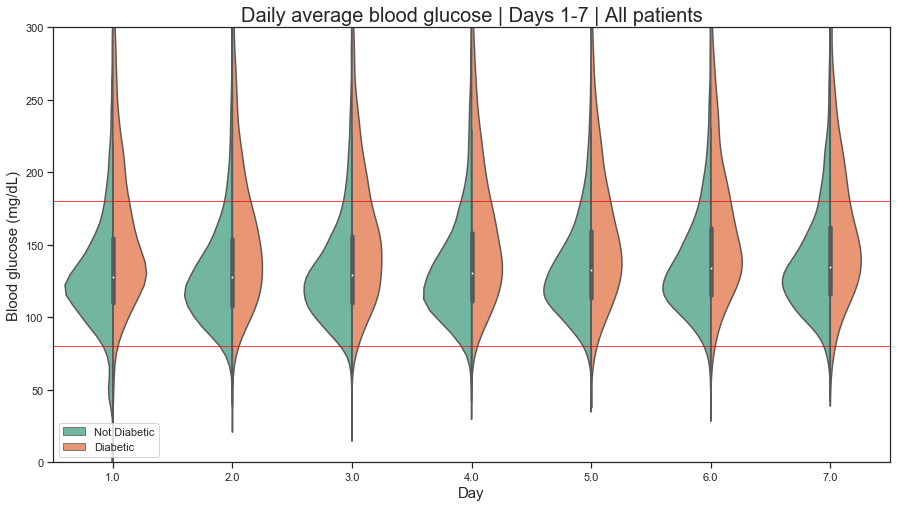

In [34]:
d_glc_plot=format_daily_glc(daily_glucose_df, "diabetic", "Diabetes", {0:"Not Diabetic", 1:"Diabetic"})

#Plot violin plot
sns.set(style="ticks")
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
ax=sns.violinplot(x=d_glc_plot["Day"], y=d_glc_plot["Glucose"], hue=d_glc_plot["Diabetes"], hue_order=["Not Diabetic", "Diabetic"] ,split=True, palette="Set2", zorder=1)

#Add patches to show regions which are in and out of control
add_glucose_guidlines(alpha=0, lines=True)


#Change violinplot formatting
plt.title("Daily average blood glucose | Days 1-7 | All patients", fontsize=20)
plt.ylabel("Blood glucose (mg/dL)", fontsize=15)
plt.xlabel("Day", fontsize=15)
plt.ylim(0,300)
plt.legend(loc='lower left')
plt.show()

#### Glucose Control on Days 1-7 for all patients, split by expiry status


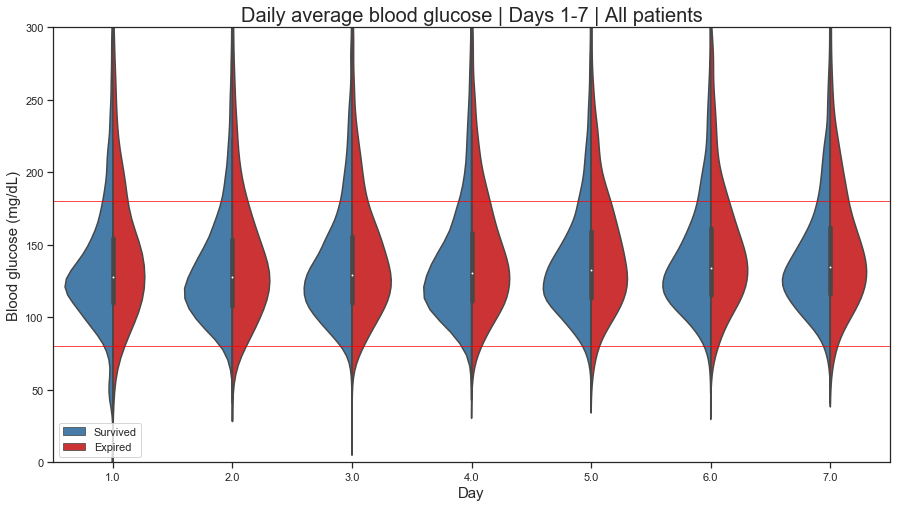

In [55]:
d_glc_plot=format_daily_glc(daily_glucose_df, "h_exp", "In-Hospital Mortality", {0:"Survived", 1:"Expired"})


#Plot violin plot
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
sns.set(style="ticks")
palette=[sns.color_palette("Set1")[1], sns.color_palette("Set1")[0]]
ax=sns.violinplot(x=d_glc_plot["Day"], y=d_glc_plot["Glucose"], hue=d_glc_plot["In-Hospital Mortality"],split=True, palette=palette, zorder=1)

#Add patches to show regions which are in and out of control
add_glucose_guidlines(alpha=0, lines=True)



#Change violinplot formatting
plt.title("Daily average blood glucose | Days 1-7 | All patients", fontsize=20)
plt.ylabel("Blood glucose (mg/dL)", fontsize=15)
plt.xlabel("Day", fontsize=15)
plt.ylim(0,300)
plt.legend(loc='lower left')
plt.show()

#### Glucose Control on Days 1-7 for patients who stayed at least 7 days, split by diabetes status

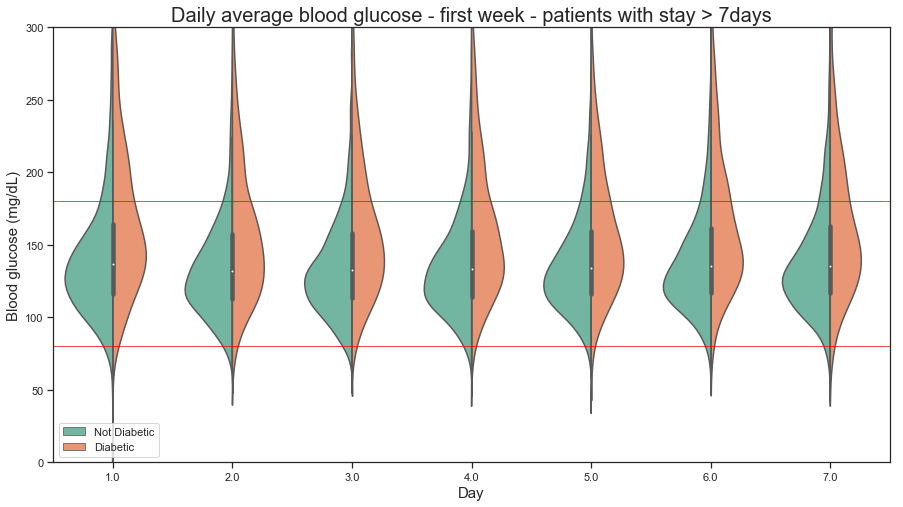

Comparing days 1 and 7 Ks_2sampResult(statistic=0.030519480519480502, pvalue=0.111487774696041)


In [36]:
#Daily average blood glucose over the first week, for patients who are in all week

#Create a long-form dataframe
d_glc_plot_7D=pd.melt(frame=daily_glucose_df.iloc[:,0:7].dropna().reset_index(), id_vars="index", value_name="Glucose", var_name="Day")

#Change timestamp into integer for easier plotting, and make first day '1'
d_glc_plot_7D["Day"]=(d_glc_plot_7D["Day"].dt.days.astype(int)+1)

#join diabetic status from admissions on icustay_id
d_glc_plot_7D=d_glc_plot_7D.rename(index=str, columns={"index": "icustay"})
d_glc_plot_7D=admissions[["diabetic", "icustay"]].merge(d_glc_plot_7D,  "left", on="icustay")
d_glc_plot_7D=d_glc_plot_7D.rename(index=str, columns={"diabetic": "Diabetes"})
d_glc_plot_7D["Diabetes"]=d_glc_plot_7D["Diabetes"].map({0:"Not Diabetic", 1:"Diabetic"})

#Plot violin plot
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
sns.set(style="ticks")
ax=sns.violinplot(x=d_glc_plot_7D["Day"], y=d_glc_plot_7D["Glucose"], hue=d_glc_plot_7D["Diabetes"], hue_order=["Not Diabetic", "Diabetic"], split=True, palette="Set2", zorder=1)

#Add patches to show regions which are in and out of control
add_glucose_guidlines(alpha=0, lines=True)

#Change violinplot formatting
plt.title("Daily average blood glucose - first week - patients with stay > 7days", fontsize=20)
plt.ylabel("Blood glucose (mg/dL)", fontsize=15)
plt.xlabel("Day", fontsize=15)
plt.ylim(0,300)
plt.legend(loc='lower left')
plt.show()

#Kolmogorov smirnov test to see whether days 1 and 7 are drawn from the same distribution
print('Comparing days 1 and 7', ks_2samp(d_glc_plot_7D.loc[d_glc_plot_7D['Day']==1]['Glucose'].values, d_glc_plot_7D.loc[d_glc_plot_7D['Day']==7]['Glucose'].values))

### Proportion out of bounds on days 1 and 7

Here I calcualte statistics for how many patients are outside the recommended bounds on a given day and test whether there is statisitically significant variation between the two days.

In [91]:
#This function uses a named dataframe, so is defined here, instead of at the top of the file

def proportion_out_of_bounds_1to7(high, low, method='average'):

    if method=='average':

        prop=proportion_beyond_lim(d_glc_plot, low, 'Not Diabetic', 1, 'hypo')
        print('Day 1, not diabetic, proportion with average below', low ,'mg/dL:', prop)

        prop=proportion_beyond_lim(d_glc_plot, low, 'Diabetic', 1, 'hypo')
        print('Day 1, diabetic, proportion with average below', low ,'mg/dL:', prop)

        prop=proportion_beyond_lim(d_glc_plot, low, 'Not Diabetic', 7, 'hypo')
        print('Day 7, not diabetic, proportion with average below', low ,'mg/dL:', prop)

        prop=proportion_beyond_lim(d_glc_plot, low, 'Diabetic', 7, 'hypo')
        print('Day 7, diabetic, proportion with average below', low ,'mg/dL:', prop)

        prop=proportion_beyond_lim(d_glc_plot, high, 'Not Diabetic', 1, 'hyper')
        print('Day 1, not diabetic, proportion with average above', high ,'mg/dL:', prop)

        prop=proportion_beyond_lim(d_glc_plot, high, 'Diabetic', 1, 'hyper')
        print('Day 1, diabetic, proportion with average above', high ,'mg/dL:', prop)

        prop=proportion_beyond_lim(d_glc_plot, high, 'Not Diabetic', 7, 'hyper')
        print('Day 7, not diabetic, proportion with average above', high ,'mg/dL:', prop)

        prop=proportion_beyond_lim(d_glc_plot, high, 'Diabetic', 7, 'hyper')
        print('Day 7, diabetic, proportion with average above', high ,'mg/dL:', prop)
        
    if method=='minmax':

        prop=proportion_beyond_lim(d_glc_plot_low, low, 'Not Diabetic', 1, 'hypo')
        print('Day 1, not diabetic, proportion with minimum below', low ,'mg/dL:', prop)

        prop=proportion_beyond_lim(d_glc_plot_low, low, 'Diabetic', 1, 'hypo')
        print('Day 1, diabetic, proportion with minimum below', low ,'mg/dL:', prop)

        prop=proportion_beyond_lim(d_glc_plot_low, low, 'Not Diabetic', 7, 'hypo')
        print('Day 7, not diabetic, proportion with minimum below', low ,'mg/dL:', prop)

        prop=proportion_beyond_lim(d_glc_plot_low, low, 'Diabetic', 7, 'hypo')
        print('Day 7, diabetic, proportion with minimum below', low ,'mg/dL:', prop)

        prop=proportion_beyond_lim(d_glc_plot_high, high, 'Not Diabetic', 1, 'hyper')
        print('Day 1, not diabetic, proportion with maximum above', high ,'mg/dL:', prop)

        prop=proportion_beyond_lim(d_glc_plot_high, high, 'Diabetic', 1, 'hyper')
        print('Day 1, diabetic, proportion with maximum above', high ,'mg/dL:', prop)

        prop=proportion_beyond_lim(d_glc_plot_high, high, 'Not Diabetic', 7, 'hyper')
        print('Day 7, not diabetic, proportion with maximum above', high ,'mg/dL:', prop)

        prop=proportion_beyond_lim(d_glc_plot_high, high, 'Diabetic', 7, 'hyper')
        print('Day 7, diabetic, proportion with maximum above', high ,'mg/dL:', prop)
        
        
    print('\n')
    
    return None
    
    


In [93]:
proportion_out_of_bounds_1to7(high=180, low=80, method='average')
proportion_out_of_bounds_1to7(high=180, low=80, method='minmax')
proportion_out_of_bounds_1to7(high=200, low=50, method='minmax')

Day 1, not diabetic, proportion with average below 80 mg/dL: 0.0606
Day 1, diabetic, proportion with average below 80 mg/dL: 0.0201
Day 7, not diabetic, proportion with average below 80 mg/dL: 0.0117
Day 7, diabetic, proportion with average below 80 mg/dL: 0.0138
Day 1, not diabetic, proportion with average above 180 mg/dL: 0.0926
Day 1, diabetic, proportion with average above 180 mg/dL: 0.2855
Day 7, not diabetic, proportion with average above 180 mg/dL: 0.1242
Day 7, diabetic, proportion with average above 180 mg/dL: 0.3223


Day 1, not diabetic, proportion with minimum below 80 mg/dL: 0.1369
Day 1, diabetic, proportion with minimum below 80 mg/dL: 0.2101
Day 7, not diabetic, proportion with minimum below 80 mg/dL: 0.0654
Day 7, diabetic, proportion with minimum below 80 mg/dL: 0.1162
Day 1, not diabetic, proportion with maximum above 180 mg/dL: 0.2789
Day 1, diabetic, proportion with maximum above 180 mg/dL: 0.611
Day 7, not diabetic, proportion with maximum above 180 mg/dL: 0.2838


### Statistical Significance tests for rates of hyperglycemia and hypoglycemia

In [37]:
hyper_1=d_glc_plot_7D.loc[d_glc_plot_7D["Day"]==1].dropna().loc[d_glc_plot_7D["Glucose"]>180].shape[0]
hyper_7=d_glc_plot_7D.loc[d_glc_plot_7D["Day"]==7].dropna().loc[d_glc_plot_7D["Glucose"]>180].shape[0]
no_hyper_1=d_glc_plot_7D.loc[d_glc_plot_7D["Day"]==1].dropna().loc[d_glc_plot_7D["Glucose"]<=180].shape[0]
no_hyper_7=d_glc_plot_7D.loc[d_glc_plot_7D["Day"]==7].dropna().loc[d_glc_plot_7D["Glucose"]<=180].shape[0]


hyper_table =   [[hyper_1, no_hyper_1],
                [hyper_7,  no_hyper_7]]

hyper_stat, hyper_p, hyper_dof, hyper_expected = stats.chi2_contingency(hyper_table)

hypo_1=d_glc_plot_7D.loc[d_glc_plot_7D["Day"]==1].dropna().loc[d_glc_plot_7D["Glucose"]<80].shape[0]
hypo_7=d_glc_plot_7D.loc[d_glc_plot_7D["Day"]==7].dropna().loc[d_glc_plot_7D["Glucose"]<80].shape[0]
no_hypo_1=d_glc_plot_7D.loc[d_glc_plot_7D["Day"]==1].dropna().loc[d_glc_plot_7D["Glucose"]>=80].shape[0]
no_hypo_7=d_glc_plot_7D.loc[d_glc_plot_7D["Day"]==7].dropna().loc[d_glc_plot_7D["Glucose"]>=80].shape[0]


hypo_table =   [[hypo_1, no_hypo_1],
                [hypo_7,  no_hypo_7]]

hypo_stat, hypo_p, hypo_dof, hypo_expected = stats.chi2_contingency(hypo_table)

print("P-value for hyper", hyper_p)
print("P-value for hypo", hypo_p)

P-value for hyper 0.4601974179856375
P-value for hypo 0.07413846757484145


## Transition probabilities between hyperglycemia and hypoglycemia - Sankey Diagram

The violin plots do not show if it is the same patients who are hyperglycemic or hypoglycemic each day, only the total number. To investigate whether the same patients are hyperglycemic this section creates a Sankey Diagram, which illustrates the probability that if a patient experience hyper(hypo)glycemia on a given day, they will experience it on the next day.

First episodes are coded based on a measurement being out of bounds, then a transition matrix (counts) is created from this information. This is plotted in a Sankey Diagram. This comparison can only be made by patients who stay for all 7 days, so while this represents a more challenging subset of patients than the average patient. Average conditional transition probabilites are calculated (e.g. given a patient is hyperglycemic on day n what is the probabilty they will be hyperglycemic on day n+1)

In [ ]:
#finding out who is in or out of control
daily_gs=daily_glucose_df.iloc[:,0:7].dropna().copy()

#define states
daily_gs[(daily_gs < 80)]=1
daily_gs[(daily_gs <= 180) & (daily_gs >= 80)]=2
daily_gs[(daily_gs > 180)]=3
#Replace states with strings (need a two step process)
#daily_gs[(daily_gs == 1)]="Hypo"
#daily_gs[(daily_gs == 2)]="Controlled"
#daily_gs[(daily_gs == 3)]="Hyper"

daily_gs=daily_gs.astype(int)
daily_gs.columns=np.arange(1,8)

### Sankey for all Patients who stay at least 7 days

In [47]:
#select only the first week of results
daily_gs_high=daily_glucose_high_df.iloc[:,0:7].dropna().copy()
daily_gs_low=daily_glucose_low_df.iloc[:,0:7].dropna().copy()

#define episodes
daily_ep=daily_gs_low.copy()
daily_ep[(daily_gs_high > 0)]=2
daily_ep[(daily_gs_high > 180)]=3
daily_ep[(daily_gs_low < 80)]=1

daily_ep=daily_ep.astype(int)
daily_ep.columns=np.arange(1,8)

#Find daily transition probabilities
transitions_ep={}

#Set up transition matrix for each day
for day in np.arange(1,7):
    transitions_ep["Day"+str(day)]=[[0]*3 for _ in range (3)]

#Count the number of transitions for each day
for day in np.arange(1,7):
    for (i,j) in zip(daily_ep[day].values, daily_ep[day+1].values):
        transitions_ep["Day"+str(day)][i-1][j-1]+=1

#Normalise the counts into probabilities
transitions_ep_prob=copy.deepcopy(transitions_ep)
for day in np.arange(1,7):
     for row in transitions_ep_prob["Day"+str(day)]:
         s = sum(row)
         if s > 0:
             row[:] = [f/s for f in row]
        
print(transitions_ep)

#set up source, target and value lists for sankey
source_list=[]
for i in np.arange(1,19):
    for n in np.arange(1,4):
        source_list.append(i)
        
target_list=[]
for i in np.arange(3,19,3):
    temp=[i+1,i+2,i+3]*3
    for item in temp:
        target_list.append(item)
        
value_list=[]
for entry in zip(source_list, target_list):
    day=int(1+(entry[0]-1)/3)
    row=((entry[0]-1)%3)
    col=(entry[1]-day*3-1)
    value_list.append(transitions_ep["Day"+str(day)][row][col])

#create dataframe for sankey
sankey_d=pd.DataFrame({"Source":source_list, "Target": target_list, "Value":value_list})
sankey_d["Colour"]="rgba(144,196,151,0.8)"
sankey_d.loc[sankey_d["Target"]%3==2,"Colour"]="rgba(252,42,58,0.8)"
sankey_d.loc[sankey_d["Target"]%3==1,"Colour"]="rgba(237,118,59,0.8)"
sankey_d["Label"]=""
sankey_d.at[3, "Label"] = "Hyperglycaemic"
sankey_d.at[1, "Label"] = "Hypoglycaemic"

i=1
for row in np.arange(0, sankey_d.shape[0]):
    if sankey_d.loc[row].loc["Target"]%3 ==0:
        sankey_d.at[row, "Label"] = "Day" + str(i)
        i+=1

        
sankey_d["Link Colour"]="rgba(32,32,32,0.2)"

data_trace=dict(
    type='sankey',
    domain= dict(
        x= [0,1],
        y= [0,1]
    ),
    orientation = "h",
    valueformat=".0f",
    node = dict(
        pad = 15,
        thickness = 30,
        line = dict(
            color = "black",
            width= 0.5
        ),
        label = sankey_d['Label'].dropna(axis=0, how="any"),
        color = sankey_d["Colour"]
    ),
    link = dict(
        source=sankey_d['Source'].dropna(axis=0, how="any"),
        target=sankey_d['Target'].dropna(axis=0, how="any"),
        value=sankey_d['Value'].dropna(axis=0, how="any"),
        color=sankey_d['Link Colour'].dropna(axis=0, how="any")
                                   
    )
)


layout =  dict(
    title = "Hypoglycemic and hyperglycemic episode flows | Days 1-7 | Patients with stay >7 days",
    height = 600,
    width = 1000,
    titlefont = dict(
      size = 20
    ),  
    font = dict(
      size = 12
    ),    
)


fig = dict(data=[data_trace], layout=layout)
py.iplot(fig, validate=False)

{'Day1': [[183, 206, 97], [125, 1072, 221], [137, 437, 598]], 'Day2': [[164, 204, 77], [123, 1319, 273], [66, 276, 574]], 'Day3': [[127, 160, 66], [127, 1383, 289], [57, 266, 601]], 'Day4': [[112, 135, 64], [111, 1411, 287], [84, 217, 655]], 'Day5': [[116, 137, 54], [95, 1415, 253], [63, 266, 677]], 'Day6': [[81, 119, 74], [98, 1444, 276], [56, 258, 670]]}


### Transition Probabilities

In [109]:
stay_hyper=[]
stay_hypo=[]
norm_hyper=[]
norm_hypo=[]

for day in transitions_ep:
    stay_hyper.append(transitions_ep[day][2][2]/sum(transitions_ep[day][2]))
    stay_hypo.append(transitions_ep[day][0][0]/sum(transitions_ep[day][0]))
    norm_hyper.append(transitions_ep[day][1][2]/sum(transitions_ep[day][1]))
    norm_hypo.append(transitions_ep[day][1][0]/sum(transitions_ep[day][1]))

print('Stays hyperglycemic', np.mean(stay_hyper))
print('Stays hypoglycemic', np.mean(stay_hypo))
print('Normal to hyperglycemic', np.mean(norm_hyper))
print('Normal to hypoglycemic', np.mean(norm_hypo))

Stays hyperglycemic 0.6377187236609626
Stays hypoglycemic 0.35640918750167555
Normal to hyperglycemic 0.15494225820456406
Normal to hypoglycemic 0.0666029831931119


## Insulin inputs 

There are several different forms of insulin used to control glucose levels. The goal of this section is to identify how much insulin is used. There are different ways to count insulin use, each with their own strengths and weaknesses. 

- Recorded inputs are a measure of the intensity of management. An input is recorded every time a new input is given (i.e. a bolus or a new infusion) or when the infusion rate is changed. It is flawed because sometimes the infusion rate changes many times in quick succession and because it does not measure the dose of insulin.
- Total units provide dosing information. However a small number of patients account for most insulin use, these patients (who dispropotionately recieve infusions) skew use statistics.
- Probability of recieving an input shows how likely a patient is to recieve an input on any given day. However, it does not account for the intensity of dosing or management.

In [58]:
ins_input_order=[("Short", "Bolus"), ("Intermediate", "Bolus"), ("Long", "Bolus"), ("Short", "Infusion"),]

#Define separate dataframe for working out which input was given on which day
insulin_inputs_daycount=insulin_inputs.copy()
insulin_inputs_daycount['icu_day']=insulin_inputs_daycount.icu_time.dt.days

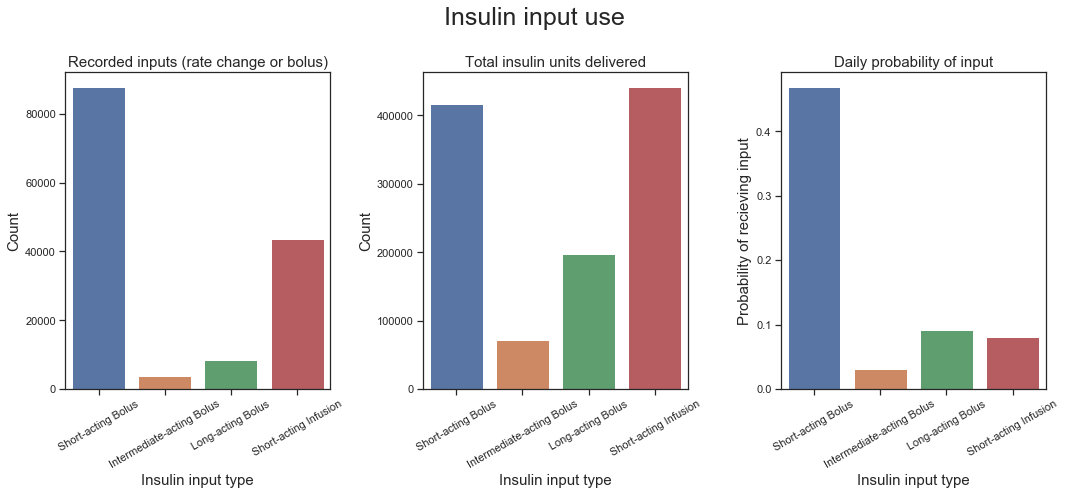

In [80]:
fig, axs = plt.subplots(1, 3, figsize = (15, 7))
gridspec.GridSpec(1,3)

plt.subplot2grid((1,3), (0,0))
plot_data=insulin_inputs.groupby(["type", "delivery"]).icustay.count().reindex(ins_input_order)
sns.barplot(x=["Short-acting Bolus", "Intermediate-acting Bolus", "Long-acting Bolus",  "Short-acting Infusion"], y=plot_data.values)
plt.title("Recorded inputs (rate change or bolus)", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.xlabel("Insulin input type", fontsize=15)
plt.xticks(rotation=30)

plt.subplot2grid((1,3), (0,1))
plot_data=insulin_inputs.groupby(["type", "delivery"]).amount.sum().reindex(ins_input_order)
sns.barplot(x=["Short-acting Bolus", "Intermediate-acting Bolus", "Long-acting Bolus",  "Short-acting Infusion"], y=plot_data.values)
plt.title("Total insulin units delivered", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.xlabel("Insulin input type", fontsize=15)
plt.xticks(rotation=30)

plt.subplot2grid((1,3), (0,2))
plot_data=insulin_inputs_daycount.groupby(["type", "delivery", 'icustay', "icu_day"]).count().groupby(["type", "delivery"]).count().reindex(ins_input_order).amount/admissions.icu_los.sum()
sns.barplot(x=["Short-acting Bolus", "Intermediate-acting Bolus", "Long-acting Bolus",  "Short-acting Infusion"], y=plot_data.values)
plt.title("Daily probability of input", fontsize=15)
plt.ylabel("Probability of recieving input", fontsize=15)
plt.xlabel("Insulin input type", fontsize=15)
plt.xticks(rotation=30)

plt.suptitle('Insulin input use', fontsize=25)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

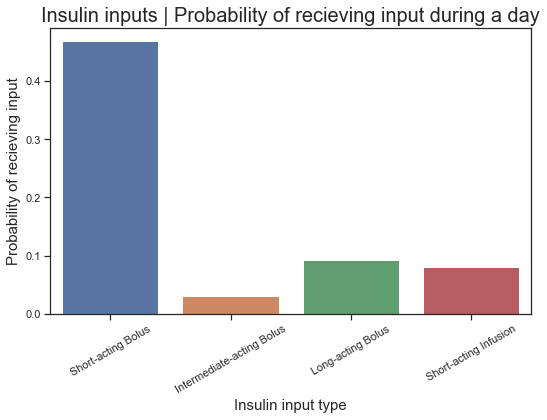

In [222]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

plot_data=insulin_inputs_daycount.groupby(["type", "delivery", 'icustay', "icu_day"]).count().groupby(["type", "delivery"]).count().reindex(ins_input_order).amount/admissions.icu_los.sum()
sns.barplot(x=["Short-acting Bolus", "Intermediate-acting Bolus", "Long-acting Bolus",  "Short-acting Infusion"], y=plot_data.values)
plt.title("Insulin inputs | Probability of recieving input during a day", fontsize=20)
plt.ylabel("Probability of recieving input", fontsize=15)
plt.xlabel("Insulin input type", fontsize=15)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## Matching insulin inputs to glucose measurements

In the ICU it is expected that insulin dosing should be preceded by a glucose measurement (particularly for short-acting insulin). Insulin inputs can therefore be matched to glucose measurement, which gives insights into dosing policies used by ICU staff.

Glucose measurements are matched to an insulin input if the measurement occured 10 minutes after or up to an hour before the measurement. The latest occuring measurement is used. Measurements which occur after the insulin dosing are included to account for order of database entry when two events occur almost similtaneously. The time period is short enough that insulin will not have a large effect on the glucose reading.

The matched measurements are visualised using heatmaps. Two types of heatmap are presented. In one the raw count is displayed, in the other the count is normalised by row. This effectively displays the probability of recieving a level of insulin given the glucose measurement indicated by the row. From this information insulin treatment policies can be inferred. To identify differences in treatments by diabetes status, these heatmaps are shown for all patients, diabetics and non-diabetics.

In [11]:
insulin_match=copy.deepcopy(insulin_inputs)
glc_match=copy.deepcopy(glc_measurements)

#drop error and warning columns
insulin_match=insulin_match.set_index("icu_time").drop(["raw_amount", 'status'], axis=1)

glc_match.columns=['icustay', 'icu_admit', 'icu_discharge', 'glc_charttime', 'hadm', 'glc_item',
       'glc_label', 'subject', 'glc_unit', 'glc_value', 'glc_type']

insulin_match.columns=['icustay', 'icu_admit', 'icu_discharge', 'subject', 'hadm', 'diagnosis',
       'ins_item', 'ins_ordercat', 'ins_input_start', 'ins_input_end', 'ins_amount', 'ins_unit',
       'ins_rate', 'ins_rateuom', 'ins_ptweight', 'ins_totalamount', 'ins_totalamountuom', 'ins_originalamount', 'ins_originalrate', 'ins_label',
        'ins_delivery', 'ins_type', 'ins_length_hr']

joined_cols= ['icustay', 'icu_admit', 'icu_discharge', 'subject', 'hadm', 'diagnosis',
       'ins_item', 'ins_ordercat', 'ins_input_start', 'ins_input_end', 'ins_amount', 'ins_unit',
       'ins_rate', 'ins_rateuom', 'ins_ptweight', 'ins_totalamount', 'ins_totalamountuom', 'ins_originalamount', 'ins_originalrate','ins_label',
       'ins_type','ins_delivery', 'glc_item', 'ins_length_hr', 'glc_charttime', 'glc_value', 'glc_unit', 'glc_label', 'glc_type']

#drop the duplicates from the glucose measurements, preferencing the non-fingerstick
glc_match=glc_match.rename_axis('icu_time')
glc_match=glc_match.sort_values(by=['icustay','icu_time', 'glc_type'])
glc_match=glc_match.reset_index().drop_duplicates(subset=['icu_time', 'icustay'], keep='last').set_index('icu_time')
glc_match=glc_match.drop(['icu_admit', 'icu_discharge', 'subject', 'hadm',], axis=1)


matched_inputs=copy.deepcopy(insulin_match)
matched_inputs=matched_inputs.reindex(columns=joined_cols)

### Matching Boluses

In [12]:
past_match_mins=10
future_match_mins=62

#separate the different bolus/infusion types (do short first)
short_boluses=insulin_match.loc[(insulin_match["ins_type"]=="Short") & (insulin_match["ins_delivery"]=="Bolus")]
#offset the index by how far we want to accept matches into the past (i.e. insulin dose occurs before glucose measurement)
short_boluses.index=short_boluses.index+timedelta(seconds=past_match_mins*60)
#set up a dictionary to add duplicate index amounts
agg_dict={}

for col in short_boluses.columns:
    agg_dict[col]="first"
agg_dict["ins_amount"]="sum"


aligned_df_list=[]
for icustay in short_boluses.icustay.unique():
    ins_df=short_boluses.loc[short_boluses.icustay ==icustay]
    glc_df=glc_match.loc[glc_match.icustay ==icustay].drop("icustay", axis=1)
    
    ins_df=ins_df.groupby(ins_df.index).agg(agg_dict)
    
    glc_df=glc_df.reindex(ins_df.index, method="ffill")
    aligned_stay=ins_df.join(glc_df, rsuffix="glc")
    aligned_df_list.append(aligned_stay)
    
aligned_df=pd.concat(aligned_df_list)

#reset the index back to normal
short_boluses.index=short_boluses.index-timedelta(seconds=past_match_mins*60)
aligned_df.index=aligned_df.index-timedelta(seconds=past_match_mins*60)

#removing entries with large timegaps
aligned_df["time_gap"]=aligned_df["ins_input_start"]-aligned_df["glc_charttime"]
old_size=aligned_df.shape[0]
aligned_df=aligned_df.loc[aligned_df["time_gap"]<=timedelta(seconds=future_match_mins*60)]
new_size=aligned_df.shape[0]
print("Exclusion: Gap between insulin administration and glucose measurement larger than", future_match_mins, "minutes in the future, or", past_match_mins , "minutes in the past")
print("Removed: ", old_size-new_size, ", ", round(100*(old_size-new_size)/old_size,4), "% of measurements")
print("Remaining: ", new_size)

Exclusion: Gap between insulin administration and glucose measurement larger than 62 minutes in the future, or 10 minutes in the past
Removed:  16855 ,  19.2262 % of measurements
Remaining:  70812


In [15]:
#create aligned_df split by diabetes status
aligned_df_dia=aligned_df.loc[aligned_df.icustay.isin(dia_icustays)]
aligned_df_no_dia=aligned_df.loc[aligned_df.icustay.isin(no_dia_icustays)]
aligned_infusions_dia=aligned_infusions.loc[aligned_infusions.icustay.isin(dia_icustays)]
aligned_infusions_no_dia=aligned_infusions.loc[aligned_infusions.icustay.isin(no_dia_icustays)]

### Bolus Heatmaps

In [17]:
def insulin_heatmap(df, glc_base=25, ins_base=2, xlow=0, xhigh=16, ylow=75, 
                    yhigh=350, cmap="Blues", norm=colors.PowerNorm(gamma=1./3.), row_norm=False,
                   fmt="2.0f", annot=True, cbar=True, ax_title=True):

    xhigh-=ins_base
    yhigh-=glc_base

    #create categories for constructing the heatmap
    df["glc_cat"]=(df["glc_value"].apply(lambda x: myround(x, glc_base))/glc_base)
    df["ins_cat"]=(df["ins_amount"].apply(lambda x: myround(x, ins_base))/ins_base)

    #create dataframe for the heatmap using pivot_table
    heat_df=pd.pivot_table(df, values="icustay", index=["glc_cat"], columns=["ins_cat"], aggfunc="count")

    #drop the unneeeded categorical variables
    df=df.drop(["glc_cat", "ins_cat"], axis=1)

    #trim the heatmap dataframe based on the lmits specificed
    heat_df=heat_df.loc[ylow/glc_base:yhigh/glc_base:,xlow/ins_base:xhigh/ins_base:]

    #normalize rows
    if row_norm==True:
        heat_df=heat_df.div(heat_df.sum(axis=1), axis=0)
    
    #create labels for the x and y ticks
    heat_xtick=np.arange(xlow, xhigh+ins_base*2, ins_base)
    heat_ytick=np.arange(ylow, yhigh+glc_base*2, glc_base)

    #plot heatmap
    ax=sns.heatmap(heat_df, robust=True, annot=annot, cbar=cbar, cmap=cmap, fmt=fmt, xticklabels=heat_xtick, yticklabels=heat_ytick, norm=norm)

    #axis_titles
    if ax_title==True:
        plt.ylabel("Blood glucose (mg/dL)", fontsize=20)
        plt.xlabel("Insulin dose (units)", fontsize=20)
    else:
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)

    #invert axis and offset labels
    ax.invert_yaxis()
    ax.set_yticks(np.arange(0, ((yhigh-ylow)/glc_base)+2))
    ax.set_xticks(np.arange(0, ((xhigh-xlow)/ins_base)+2))
    
    sns.set(font_scale=1)

#### Non-normalised bolus heatmap

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



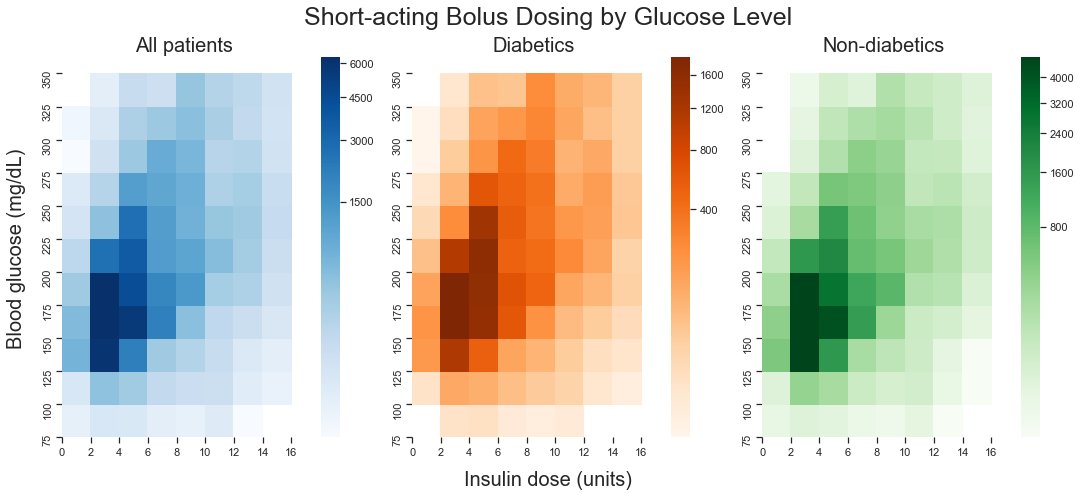

In [21]:
sns.set(style="ticks", font_scale=1)

fig, axs = plt.subplots(2, 1, figsize = (18, 7))
gridspec.GridSpec(1,3)


plt.subplot2grid((1,3), (0,0))
insulin_heatmap(aligned_df, cmap="Blues", norm=colors.PowerNorm(gamma=1./3.), ax_title=False, annot=False)
plt.title("All patients", fontsize=20)

sns.set(style="ticks", font_scale=1)
plt.subplot2grid((1,3), (0,1))
insulin_heatmap(aligned_df_dia, cmap="Oranges", norm=colors.PowerNorm(gamma=1./3.), ax_title=False, annot=False)
plt.title("Diabetics", fontsize=20)

sns.set(style="ticks", font_scale=1)
plt.subplot2grid((1,3), (0,2))
insulin_heatmap(aligned_df_no_dia, cmap="Greens", norm=colors.PowerNorm(gamma=1./3.), ax_title=False, annot=False)
plt.title("Non-diabetics", fontsize=20)

plt.suptitle("Short-acting Bolus Dosing by Glucose Level", fontsize=25)

fig.text(0.5, 0.04, 'Insulin dose (units)', ha='center', va='center', fontsize=20)
fig.text(0.09, 0.5, 'Blood glucose (mg/dL)', ha='center', va='center', rotation='vertical', fontsize=20)

fig.subplots_adjust(wspace=.15)
plt.show()

sns.set(font_scale=1)

#### Normalised bolus heatmap

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



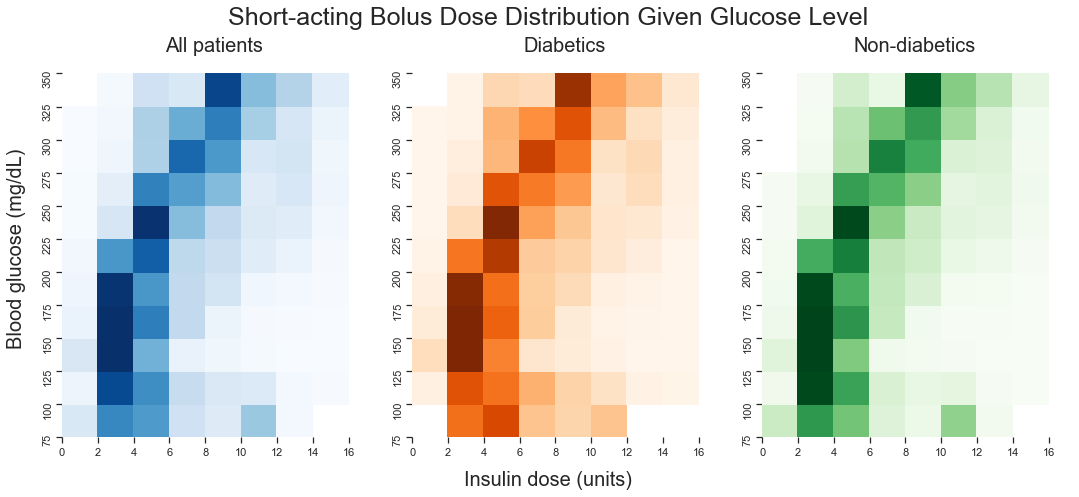

In [22]:
sns.set(style="ticks", font_scale=1)

fig, axs = plt.subplots(2, 1, figsize = (18, 7))
gridspec.GridSpec(1,3)


plt.subplot2grid((1,3), (0,0))
insulin_heatmap(aligned_df, cmap="Blues", norm=colors.PowerNorm(gamma=1./1.), row_norm=True, annot=False, cbar=False, ax_title=False)
plt.title("All patients", fontsize=20)

sns.set(style="ticks", font_scale=1)
plt.subplot2grid((1,3), (0,1))
insulin_heatmap(aligned_df_dia, cmap="Oranges", norm=colors.PowerNorm(gamma=1./1.), row_norm=True, annot=False, cbar=False, ax_title=False)
plt.title("Diabetics", fontsize=20)

sns.set(style="ticks", font_scale=1)
plt.subplot2grid((1,3), (0,2))
insulin_heatmap(aligned_df_no_dia, cmap="Greens", norm=colors.PowerNorm(gamma=1./1.), row_norm=True, annot=False, cbar=False, ax_title=False)
plt.title("Non-diabetics", fontsize=20)

plt.suptitle("Short-acting Bolus Dose Distribution Given Glucose Level", fontsize=25)
fig.subplots_adjust(wspace=.15)

fig.text(0.5, 0.04, 'Insulin dose (units)', ha='center', va='center', fontsize=20)
fig.text(0.09, 0.5, 'Blood glucose (mg/dL)', ha='center', va='center', rotation='vertical', fontsize=20)

plt.show()

sns.set(font_scale=1)

## Individual ICU Stays

Aggregate statisitics are not neccessarily indicative of individual patient experiences. This code plots the glucose measurements, insulin inputs and dextrose inputs for individual ICU stays. The code can be run on every ICU stays in the cohort to generate family of plots.

In [86]:
#Created copies of df with a different index to construct plots of individual ICU stays

#glucose
glc_measurements_ind=ts_to_days(glc_measurements.copy())

#insulin boluses
insulin_bolus_ind=insulin_bolus.copy().set_index("icu_time")
insulin_bolus_ind=ts_to_days(insulin_bolus_ind)

#insulin infusions
insulin_infusion_ind=insulin_infusion.copy().set_index("icu_time")
insulin_infusion_ind=ts_to_days(insulin_infusion_ind)
insulin_infusion_ind["length_day"]=insulin_infusion_ind["length_hr"]/24
insulin_infusion_ind["start_time"]=insulin_infusion_ind.index
insulin_infusion_ind["end_time"]=insulin_infusion_ind["start_time"]+insulin_infusion_ind["length_day"]

#dextrose_d50s
d50_ind=dextrose_inputs.loc[(dextrose_inputs["delivery"]=="Bolus") & (dextrose_inputs["concentration"]==0.5)].set_index("icu_time")
d50_ind=ts_to_days(d50_ind)

In [95]:
#Creates a plot of a given ICU stay. Defined here because it uses named dfs
def plot_icustay(icustay, save=False, show=True):
    
    fig, ax1 = plt.subplots(1, 1, figsize = (15, 8))


    #define length of stay
    icu_los= admissions.loc[admissions.icustay==icustay].icu_los.values[0]
    
    #only perform if there is insulin dosing
    if len(insulin_inputs.loc[(insulin_inputs.icustay==icustay)])>0:
    
        #create second axis
        ax2 = ax1.twinx()
        
        if len(insulin_bolus_ind.loc[(insulin_bolus_ind.icustay==icustay) & (insulin_bolus_ind.type=="Long")])>0:
            #plot long insulin boluses
            ts_ins_long=insulin_bolus_ind.loc[(insulin_bolus_ind.icustay==icustay) & (insulin_bolus_ind.type=="Long")].amount
            ax2.plot(ts_ins_long, color="green", marker='D', markersize=12, linestyle="None", label="Long-acting insulin bolus")
        
        if len(insulin_bolus_ind.loc[(insulin_bolus_ind.icustay==icustay) & (insulin_bolus_ind.type=="Intermediate")])>0:
            #plot intermediate insulin boluses
            ts_ins_int=insulin_bolus_ind.loc[(insulin_bolus_ind.icustay==icustay) & (insulin_bolus_ind.type=="Intermediate")].amount
            ax2.plot(ts_ins_int, color="darkviolet", marker='D', markersize=12, linestyle="None", label="Intermediate-acting insulin bolus")

        if len(insulin_bolus_ind.loc[(insulin_bolus_ind.icustay==icustay) & (insulin_bolus_ind.type=="Short")])>0:
            #plot short insulin boluses
            ts_ins_short=insulin_bolus_ind.loc[(insulin_bolus_ind.icustay==icustay) & (insulin_bolus_ind.type=="Short")].amount
            ax2.plot(ts_ins_short, color="blue", marker='D', markersize=12, linestyle="None", label="Short-acting insulin bolus")

        if len(insulin_infusion_ind.loc[insulin_infusion_ind.icustay==icustay])>0:
            #plot insulin infusions
            ts_ins_inf=insulin_infusion_ind.loc[insulin_infusion_ind.icustay==icustay][["rate", "start_time", "end_time"]]

            #define index positions
            rate_index=0
            start_index=1
            end_index=2
            prev_row=None
    
            for row in ts_ins_inf.itertuples(index=False):
                ax2.plot([row[start_index], row[end_index]], [row[rate_index], row[rate_index]],color="palevioletred", linewidth=3)
                #first row
                if prev_row is None:
                    ax2.plot([row[start_index], row[start_index]], [0, row[rate_index]], color="palevioletred", linewidth=3)
                #middle row with connection
                elif row[start_index]-prev_row[end_index]<(5/24/60):
                    ax2.plot([row[start_index], row[start_index]], [prev_row[rate_index], row[rate_index]], color="palevioletred", linewidth=3)
                #middle row without connection
                else:
                    ax2.plot([prev_row[end_index], prev_row[end_index]], [prev_row[rate_index], 0], color="palevioletred", linewidth=3)
                    ax2.plot([row[start_index], row[start_index]], [0, row[rate_index]], color="palevioletred", linewidth=3)
                    #ax2.plot([prev_row[end_index], row[start_index]], [0, 0], color="palevioletred", linewidth=3)
                prev_row=row
            #final row
            ax2.plot([prev_row[end_index], prev_row[end_index]], [prev_row[rate_index], 0], color="palevioletred", linewidth=3, label="Insulin Infusion")

    if len(d50_ind.loc[d50_ind.icustay==icustay])>0:
        #create third axis
        ax3 = ax1.twinx()

        if len(insulin_inputs.loc[(insulin_inputs.icustay==icustay)])>0:
            ax3.spines["right"].set_position(("axes", 1.08))
            make_patch_spines_invisible(ax3)
            ax3.spines["right"].set_visible(True)

        #plot d50s
        ts_d50=d50_ind.loc[d50_ind.icustay==icustay].amount
        ax3.plot(ts_d50, color="darkorange", marker='p', markersize=15, linestyle="None", label="D50 Dextrose Bolus")


    #plot glucose
    ts_glc=glc_measurements_ind.loc[glc_measurements_ind.icustay==icustay].value
    ax1.plot(ts_glc, color="red", marker='o', markersize=6, linewidth=2.2, label="Glucose Level")

    #add_glucose_guidlines(ax=ax1)

    #get legend
    lines, labels = ax1.get_legend_handles_labels()
    lines_collection=lines
    labels_collection=labels
    if len(insulin_inputs.loc[(insulin_inputs.icustay==icustay)])>0:
        lines2, labels2 = ax2.get_legend_handles_labels()
        lines_collection+=lines2
        labels_collection+=labels2
        ax2.set_ylabel("Insulin input amount (units or units/hour)", fontsize=15)
        ax2.set_ylim(0)
    
    if len(d50_ind.loc[d50_ind.icustay==icustay])>0:
        lines3, labels3 = ax3.get_legend_handles_labels()
        lines_collection+=lines3
        labels_collection+=labels3
        ax3.set_ylabel("D50 Dextrose Amount (mL)", fontsize=15)
        ax3.set_ylim(0)
    
    plt.legend(lines_collection, labels_collection, loc=0)
    plt.title("Blood Glucose management: ICU Stay %s" % icustay, fontsize=20)
    ax1.set_ylabel("Blood glucose (mg/dL)", fontsize=15)
    ax1.set_xlabel("Time since entering ICU (days)", fontsize=15)
    plt.xlim(0,icu_los)
    ax1.set_ylim(0)

    if save==True:
        fig.savefig('\Figures\patient_journeys\journey_%s.png' % icustay)
    
    if show==True:
        plt.show()
    
    #attempt to free memory
    plt.close(fig)
    fig.clf()
    plt.close()
    gc.collect()
    

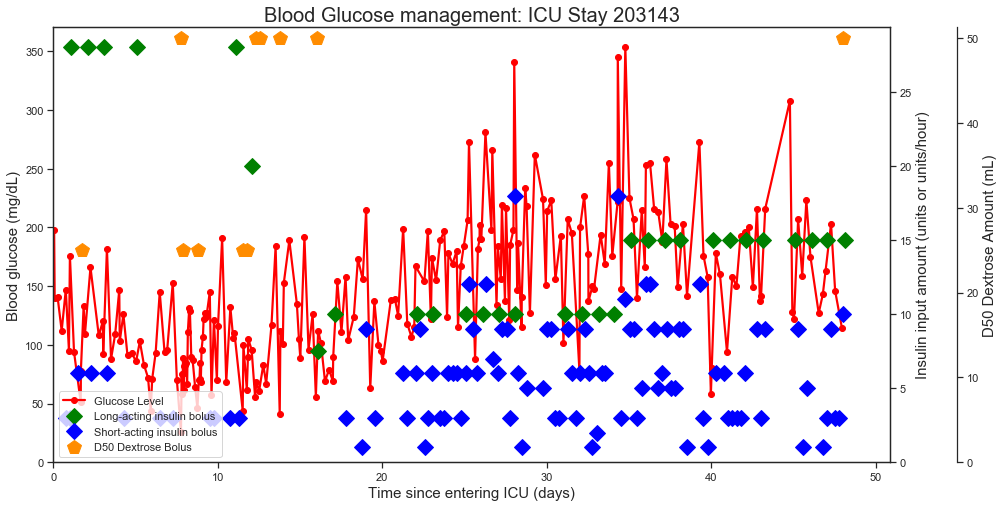

In [99]:
sns.set_style('ticks')
plot_icustay(203143, save=False)

## Effect of Insulin Infusions on Blood Sugar Control

Infusions and boluses are used on different patients and appear to have different propensities to cause hypoglycemic events and hyperglycemic events. This section investigates which patients are likely to recieve infusions and the effect of an infusion on blood sugar (comparing pre-infusion to post-infusion).

Some infusions appear to be reactive (i.e. in response to high blood sugars) and some appear to be proactive (i.e. before high blood sugars are observed). The effect of infusion on blood sugar is only considered for reactive infusions.

In [100]:
#find the length of the first insulin infusion for each person.

#somewhere to store and check the results
first_insulin_infusion=insulin_infusion.copy()

#set up the indexes
i_stay=0
i_start=1
i_end=2
i_length=3
i_admit=4

#
gap_threshold = pd.Timedelta(seconds=60*60)

#first for loop gets the dataframe of just the person
for icustay in first_insulin_infusion['icustay'].unique():
    inf_df=first_insulin_infusion.loc[first_insulin_infusion['icustay']==icustay]
    inf_length=0
    pr=[0]*5
    end_inf_flag=0
    
    #second loop looks through that dataframe (I realise now I could do this in one loop, but it still runs fast)
    for r in zip(inf_df['icustay'], inf_df['input_start'], inf_df['input_end'], inf_df['length_hr'], inf_df['icu_admit']):
        #if we are on the first entry then carry on
        if r[i_stay]!= pr[i_stay]:
            inf_length+= r[i_length]
            #set the time elapsed since admission for all rows
            since_admit=r[i_start]-r[i_admit]
            since_admit=since_admit.total_seconds()/3600
            first_insulin_infusion.loc[first_insulin_infusion['icustay']==icustay, 'first_infusion_hr_since_admit']=since_admit
        #if the infusion stops (for more than the gap threshold) then write now and raise a flag to stop writing later
        elif r[i_start] > (pr[i_end] + gap_threshold):
            first_insulin_infusion.loc[first_insulin_infusion['icustay']==icustay, 'first_infusion_length_hr']=inf_length
            end_inf_flag=1
            
        #if the infusion hasn't stopped then carry on and add the length
        elif r[i_start] <= (pr[i_end] + gap_threshold):
            inf_length+= r[i_length]
        
        #update the previous row to the row
        pr=r
    
    #only write the length if the flag isn't up for an early end
    if end_inf_flag==0:
        first_insulin_infusion.loc[first_insulin_infusion['icustay']==icustay, 'first_infusion_length_hr']=inf_length

#join in the first care unit from the admissions table
first_insulin_infusion=admissions[['first_careunit', 'icustay']].merge(first_insulin_infusion, "inner", on='icustay')

### Who gets an infusion?

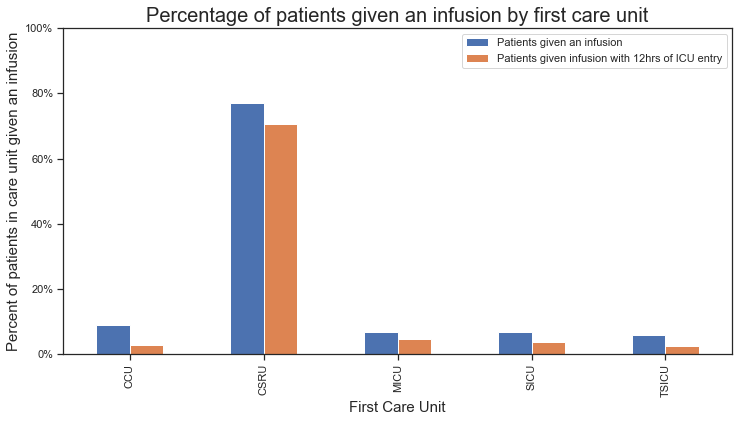

In [101]:
#What proportion of the people in each care unit got an infusion?

infusion_care_unit_count=first_insulin_infusion[['first_careunit', 'icustay', 'first_infusion_length_hr']].groupby('icustay').first().groupby('first_careunit').count()
infusion_care_unit_count=infusion_care_unit_count.join(admissions[['first_careunit', 'subject']].groupby('first_careunit').count())

infusion_care_unit_count.columns=['Infusion_patients', 'Total_patients']
infusion_care_unit_count['Proportion_infusion']=infusion_care_unit_count['Infusion_patients']/infusion_care_unit_count['Total_patients']

#Now add in what proportion got a proactive infusion (less than 12 hrs since entering)

proactive_infusion_care_unit_count=first_insulin_infusion[['first_careunit', 'icustay', 'first_infusion_length_hr']].loc[first_insulin_infusion['first_infusion_hr_since_admit']<12].groupby('icustay').first().groupby('first_careunit').count()
infusion_care_unit_count=infusion_care_unit_count.join(proactive_infusion_care_unit_count)
infusion_care_unit_count=infusion_care_unit_count.rename(columns={'first_infusion_length_hr': 'Proactive_infusion_patients'})
infusion_care_unit_count['Proportion_proactive_infusions']=infusion_care_unit_count['Proactive_infusion_patients']/infusion_care_unit_count['Total_patients']
infusion_care_unit_count['Proportion_infusions_proactive']=infusion_care_unit_count['Proactive_infusion_patients']/infusion_care_unit_count['Infusion_patients']

#plot on a bar chart
fig, ax = plt.subplots(1, 1, figsize = (12, 6))
infusion_care_unit_count[['Proportion_infusion', 'Proportion_proactive_infusions']].plot.bar(ax=ax)
ax.legend(['Patients given an infusion', 'Patients given infusion with 12hrs of ICU entry'])
plt.title("Percentage of patients given an infusion by first care unit", fontsize=20)
plt.xlabel("First Care Unit", fontsize=15)
plt.ylabel("Percent of patients in care unit given an infusion", fontsize=15)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.ylim(0,1)
plt.show()

In [38]:
#Proportion of patients in the CSRU
print('Percent of patients seen by CSRU:', round(infusion_care_unit_count.loc['CSRU', 'Total_patients']/infusion_care_unit_count['Total_patients'].sum()*100, 2), '%')
print('Percent of infusions given by CSRU:', round(infusion_care_unit_count.loc['CSRU', 'Infusion_patients']/infusion_care_unit_count['Infusion_patients'].sum()*100, 2), '%')


Percent of patients seen by CSRU: 15.8 %
Percent of infusions given by CSRU: 67.25 %


In [103]:
#How many patients with the identified diagnoses have infusions and how many occur at less than 12 hours?

target_diagnoses=['DIABETIC KETOACIDOSIS', 'DKA', 'HYPERGLYCEMIA', 'HYPEROSMOLAR SYNDROME']
icustay_target_diganoses=admissions.loc[admissions['diagnosis'].str.contains('|'.join(target_diagnoses))].icustay.nunique()
icustay_target_diganoses_infusion=first_insulin_infusion[['icustay', 'first_infusion_length_hr', 'diagnosis']].loc[first_insulin_infusion['diagnosis'].str.contains('|'.join(target_diagnoses))].icustay.nunique()
icustay_target_diganoses_proactive_infusion=first_insulin_infusion[['icustay', 'first_infusion_length_hr', 'diagnosis']].loc[(first_insulin_infusion['first_infusion_hr_since_admit']<12) & (first_insulin_infusion['diagnosis'].str.contains('|'.join(target_diagnoses)))].icustay.nunique()

print('Number of patients with target diagnoses', icustay_target_diganoses)
print('Number of patients with target diagnoses and an infusion', icustay_target_diganoses_infusion)
print('Number of patients with target diagnoses and a proactive infusion', icustay_target_diganoses_proactive_infusion)

print('Proportion of patients with target diagnoses who have an infusion', icustay_target_diganoses_infusion/icustay_target_diganoses)
print('Proportion of patients with target diagnoses who have a proactive infusion', icustay_target_diganoses_proactive_infusion/icustay_target_diganoses)
print('Proportion of infusions which occur in first 12 hours in target diagnosis patients', icustay_target_diganoses_proactive_infusion/icustay_target_diganoses_infusion)

Number of patients with target diagnoses 282
Number of patients with target diagnoses and an infusion 267
Number of patients with target diagnoses and a proactive infusion 264
Proportion of patients with target diagnoses who have an infusion 0.9468085106382979
Proportion of patients with target diagnoses who have a proactive infusion 0.9361702127659575
Proportion of infusions which occur in first 12 hours in target diagnosis patients 0.9887640449438202


### Hourly Glucose readings before and after infusion

In [104]:
#Find the time of the first infusion for each person. Get all glucose measurements 12 hr before and 12 hr after, average. Plot on histograms
start_iloc = inf_df.columns.get_loc('input_start')
step_hours=2
gap_hours=6
gap=pd.Timedelta(seconds=gap_hours*60*60)
av_glc_before=[]
av_glc_after=[]
all_glc_before=[]
all_glc_after=[]
time_step=pd.Timedelta(seconds=step_hours*60*60)
n_step=6

#Exclusions

#First infusion at least 12 hours long
included_stays=first_insulin_infusion.loc[first_insulin_infusion['first_infusion_length_hr']>(n_step*step_hours)].icustay.unique()
#Has 12 hours before an infusion begins
included_stays=np.intersect1d(included_stays, first_insulin_infusion.loc[first_insulin_infusion['first_infusion_hr_since_admit']>n_step*step_hours].icustay.unique())
#Not admitted to the CSRU
included_stays=np.intersect1d(included_stays, admissions.loc[admissions['first_careunit']!='CSRU'].icustay.unique())
#Does not have one of the target diagnoses (i.e. one which should be treated with an infusion straight away)
included_stays=np.intersect1d(included_stays, admissions.loc[~admissions['diagnosis'].str.contains('|'.join(target_diagnoses))].icustay.unique())

i=0

glc_infusion_dict={}
#going to create a dictionary, with an interger key and containing a list [icustay, mean_glc, hour]
for icustay in included_stays:
    inf_df=insulin_infusion.loc[insulin_infusion.icustay==icustay]
    first_infusion = inf_df.iat[0, start_iloc]
    bolus_df=insulin_bolus.loc[insulin_bolus.icustay==icustay]
    glc_df=glc_measurements.loc[glc_measurements.icustay==icustay]
    d50_df=dextrose_bolus.loc[(dextrose_bolus['concentration']==0.5) & (dextrose_bolus.icustay==icustay)]
    
    for step in range(-n_step, n_step):
        hour=step*step_hours
        hour_glc=glc_df.loc[(glc_df['charttime'] > (first_infusion + (time_step*step))) & (glc_df['charttime'] < first_infusion + (time_step*(step+1)))]
        hour_bolus=bolus_df.loc[(bolus_df['input_start'] > (first_infusion + (time_step*step))) & (bolus_df['input_start'] < first_infusion + (time_step*(step+1)))]
        hour_inf=inf_df.loc[(inf_df['input_start'] > (first_infusion + (time_step*step))) & (inf_df['input_start'] < first_infusion + (time_step*(step+1)))]
        hour_d50=d50_df.loc[(d50_df['input_start'] > (first_infusion + (time_step*step))) & (d50_df['input_start'] < first_infusion + (time_step*(step+1)))]

        mean_glc=hour_glc.value.values.mean()
        try:
            min_glc=hour_glc.value.values.min()
        except(ValueError):
            min_glc=np.nan
        count_glc=len(hour_glc)
        count_bolus=len(hour_bolus)
        count_inf=len(hour_inf)
        count_d50=len(hour_d50)
        inf_ins=hour_inf.amount.sum()
        bolus_ins=hour_bolus.amount.sum()
        total_ins=inf_ins+bolus_ins
        
        glc_infusion_dict[i]=[icustay, mean_glc, min_glc, count_glc, count_bolus, count_inf, count_d50, total_ins, hour]
        
        i+=1
        
hour_infusion=pd.DataFrame.from_dict(glc_infusion_dict, orient='index', columns=['icustay', 'mean_glc', 'min_glc', 'count_glc', 'count_bolus', 'count_inf', 'count_d50', 'total_ins', 'hour'])

print('Number of included stays', len(included_stays))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning:

Mean of empty slice.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars



Number of included stays 371


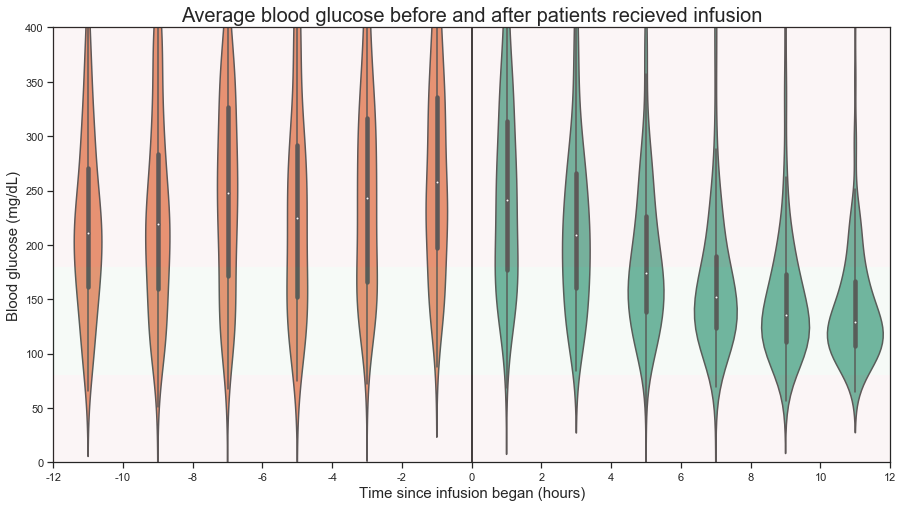

In [105]:
sns.set(style="ticks")
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
palette=[sns.color_palette("Set2")[1]]*n_step+[sns.color_palette("Set2")[0]]*n_step
ax=sns.violinplot(x=hour_infusion["hour"], y=hour_infusion["mean_glc"], palette=palette)
add_glucose_guidlines()
ax.axvline(x=n_step-0.5, label="Zero line", color="black")
plt.ylim(0, 400)
plt.xlabel('Time since infusion began (hours)', fontsize=15)
plt.ylabel("Blood glucose (mg/dL)", fontsize=15)
plt.title("Average blood glucose before and after patients recieved infusion", fontsize=20)
plt.xticks(np.arange(-0.5, 12.5), np.arange(-n_step*step_hours, (n_step+1)*step_hours, step_hours))
plt.show()

In [43]:
#total insulin used before and after

total_ins_before=hour_infusion.loc[(hour_infusion['hour']<0)].total_ins.sum()
total_ins_after=hour_infusion.loc[(hour_infusion['hour']>=0)].total_ins.sum()
print("Insulin used in before period:", round(total_ins_before), "units")
print("Insulin used in after period:", round(total_ins_after), "units")
print("Ratio:", round(total_ins_after/total_ins_before,3))

Insulin used in before period: 4562.0 units
Insulin used in after period: 29782.0 units
Ratio: 6.528


In [327]:
glc_count_prior=hour_infusion.loc[hour_infusion['hour']<0].count_glc.sum()
glc_count_after=hour_infusion.loc[hour_infusion['hour']>=0].count_glc.sum()

bolus_count_prior=hour_infusion.loc[hour_infusion['hour']<0].count_bolus.sum()
bolus_count_after=hour_infusion.loc[hour_infusion['hour']>=0].count_bolus.sum()

inf_count_prior=hour_infusion.loc[hour_infusion['hour']<0].count_inf.sum()
inf_count_after=hour_infusion.loc[hour_infusion['hour']>=0].count_inf.sum()

d50_count_prior=hour_infusion.loc[hour_infusion['hour']<0].count_d50.sum()
d50_count_after=hour_infusion.loc[hour_infusion['hour']>=0].count_d50.sum()

hour_count_prior=len(hour_infusion.loc[hour_infusion['hour']<0])*2
hour_count_after=len(hour_infusion.loc[hour_infusion['hour']>=0])*2

glc_rate_prior=glc_count_prior/hour_count_prior
glc_rate_after=glc_count_after/hour_count_after
bolus_rate_prior=bolus_count_prior/hour_count_prior
bolus_rate_after=bolus_count_after/hour_count_after
inf_rate_prior=inf_count_prior/hour_count_prior
inf_rate_after=inf_count_after/hour_count_after
d50_rate_prior=d50_count_prior/hour_count_prior
d50_rate_after=d50_count_after/hour_count_after


print("Glucose measurements - Before: ", round(glc_count_prior,2), "glc   ",  round(glc_rate_prior,2), "glc/hr      After: ", round(glc_count_after,2), "glc   ",  round(glc_rate_after,2), "glc/hr")
print("Insulin boluses - Before: ", round(bolus_count_prior,2), "boluses   ",  round(bolus_rate_prior,2), "boluses/hr      After: ", round(bolus_count_after,2), "boluses   ",  round(bolus_rate_after,2), "boluses/hr")
print("Insulin infusions - Before: ", round(inf_count_prior,2), "infusions   ",  round(inf_rate_prior,2), "infusions/hr      After: ", round(inf_count_after,2), "infusions   ",  round(inf_rate_after,2), "infusions/hr")
print("D50 Boluses - Before: ", round(d50_count_prior,2), "D50:   ",  round(d50_rate_prior,2), "D50/hr      After: ", round(d50_count_after,2), "D50   ",  round(d50_rate_after,2), "D50/hr")

Glucose measurements - Before:  1649 glc    0.37 glc/hr      After:  3813 glc    0.86 glc/hr
Insulin boluses - Before:  441 boluses    0.1 boluses/hr      After:  214 boluses    0.05 boluses/hr
Insulin infusions - Before:  0 infusions    0.0 infusions/hr      After:  2041 infusions    0.46 infusions/hr
D50 Boluses - Before:  3 D50:    0.0 D50/hr      After:  10 D50    0.0 D50/hr


In [328]:
print("total infusions:", insulin_infusion.icustay.nunique())
print("infusions included in the analysis:", hour_infusion.icustay.nunique())
print("proportion included:", round(hour_infusion.icustay.nunique()/insulin_infusion.icustay.nunique(),4))

total infusions: 3569
infusions included in the analysis: 371
proportion included: 0.104
